In [1]:
# Import the libraries we need to use in this lab
from __future__ import print_function
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import ast
import time
# model trainin set
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize, StandardScaler
from sklearn.utils.class_weight import compute_sample_weight
#models 
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
#model evaluation
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error, r2_score
from pathlib import Path

In [30]:
loop7_data = pd.read_csv(Path("/Users/rezadoobary/Documents/ML-correlator/Tree classifier for graphs/mixed_loops/features_tabular/graph_7loopfeats_enhanced.csv"))
loop8_data = pd.read_csv(Path("/Users/rezadoobary/Documents/ML-correlator/Tree classifier for graphs/mixed_loops/features_tabular/graph_8loopfeats_enhanced.csv"))
loop9_data = pd.read_csv(Path("/Users/rezadoobary/Documents/ML-correlator/Tree classifier for graphs/mixed_loops/features_tabular/graph_9loopfeats_enhanced.csv"))
#loop11_data = pd.read_csv(Path("/Users/rezadoobary/Documents/ML-correlator/Tree classifier for graphs/mixed_loops/features_tabular/11loopfeats_enhanced.csv"))

/var/folders/4s/7f5zf8596_526pnhktn077f40000gn/T/ipykernel_70215/647545076.py:3: DtypeWarning: Columns (1,197) have mixed types. Specify dtype option on import or set low_memory=False.
  loop9_data = pd.read_csv(Path("/Users/rezadoobary/Documents/ML-correlator/Tree classifier for graphs/mixed_loops/features_tabular/graph_9loopfeats_enhanced.csv"))


In [33]:
loop8_data['COEFFICIENTS'].unique()

array(['0', '1', '-1', '-1/2', '1/2', '2', '-3/2', '-5', '-2'],
      dtype=object)

In [34]:
loop7_data['COEFFICIENTS'] = (loop7_data['COEFFICIENTS'].astype(str) != '0').astype(int)
loop8_data['COEFFICIENTS'] = (loop8_data['COEFFICIENTS'].astype(str) != '0').astype(int)
loop9_data['COEFFICIENTS'] = (loop9_data['COEFFICIENTS'].astype(str) != '0').astype(int)

In [35]:
loop7_data = loop7_data.replace(np.inf, np.nan)
loop8_data = loop8_data.replace(np.inf, np.nan)
loop9_data = loop9_data.replace(np.inf, np.nan)

In [36]:
# some intra-loop stuff

In [37]:
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

Fold 1 ROC AUC: 0.908
Fold 2 ROC AUC: 0.953
Fold 3 ROC AUC: 0.855
Fold 4 ROC AUC: 0.789
Fold 5 ROC AUC: 0.933

Average ROC AUC: 0.888 ± 0.059


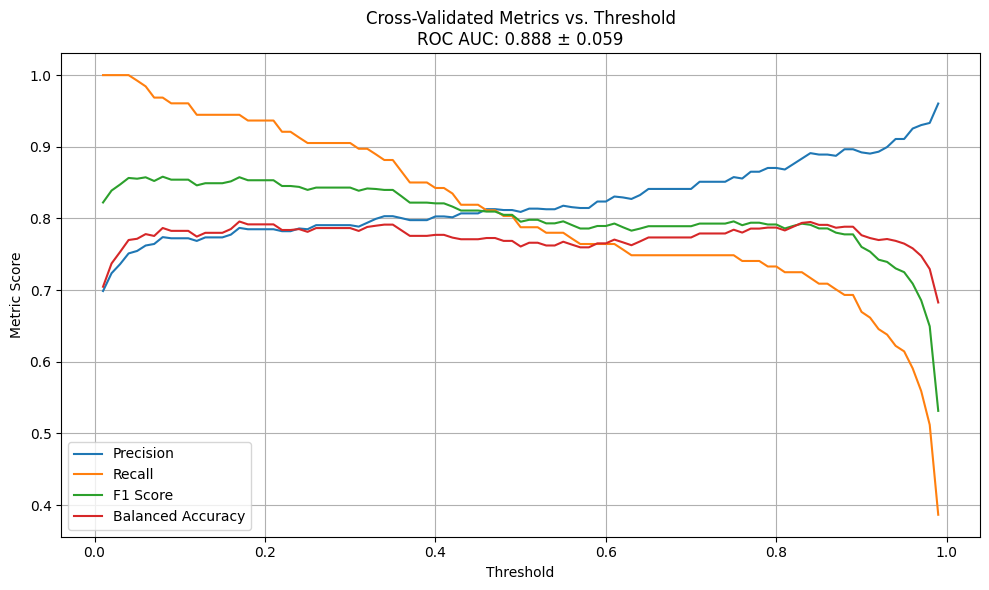

In [38]:
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    precision_score, recall_score, f1_score,
    balanced_accuracy_score, roc_auc_score
)
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import numpy as np

# --- Data ---
data = loop7_data
data_cols = [col for col in data.columns if 'COEFFICIENTS' not in col]
target_col = 'COEFFICIENTS'
X = data[data_cols].values
y = data[target_col].values.ravel()

# --- Thresholds ---
thresholds = np.linspace(0.01, 0.99, 99)
precisions = np.zeros_like(thresholds)
recalls = np.zeros_like(thresholds)
f1s = np.zeros_like(thresholds)
balanced_accuracies = np.zeros_like(thresholds)

# --- Track ROC AUC per fold
roc_aucs = []

# --- Stratified K-Fold CV ---
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for fold, (train_idx, test_idx) in enumerate(kf.split(X, y)):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    # --- Scaling (fit on train only, transform both train/test) ---
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # --- Model training ---
    model = XGBClassifier(eval_metric='logloss')
    model.fit(X_train, y_train)

    y_scores = model.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, y_scores)
    roc_aucs.append(auc)
    print(f"Fold {fold+1} ROC AUC: {auc:.3f}")

    for i, t in enumerate(thresholds):
        y_pred = (y_scores >= t).astype(int)
        precisions[i] += precision_score(y_test, y_pred, zero_division=0)
        recalls[i] += recall_score(y_test, y_pred)
        f1s[i] += f1_score(y_test, y_pred)
        balanced_accuracies[i] += balanced_accuracy_score(y_test, y_pred)

# --- Average metrics across folds ---
n_folds = kf.get_n_splits()
precisions /= n_folds
recalls /= n_folds
f1s /= n_folds
balanced_accuracies /= n_folds

# --- Report AUC ---
mean_auc = np.mean(roc_aucs)
std_auc = np.std(roc_aucs)
print(f"\nAverage ROC AUC: {mean_auc:.3f} ± {std_auc:.3f}")

# --- Plot ---
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precisions, label="Precision")
plt.plot(thresholds, recalls, label="Recall")
plt.plot(thresholds, f1s, label="F1 Score")
plt.plot(thresholds, balanced_accuracies, label="Balanced Accuracy")

plt.xlabel("Threshold")
plt.ylabel("Metric Score")
plt.title(f"Cross-Validated Metrics vs. Threshold\nROC AUC: {mean_auc:.3f} ± {std_auc:.3f}")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Fold 1 ROC AUC: 0.956
Fold 2 ROC AUC: 0.956
Fold 3 ROC AUC: 0.952
Fold 4 ROC AUC: 0.960
Fold 5 ROC AUC: 0.954

Average ROC AUC: 0.956 ± 0.003


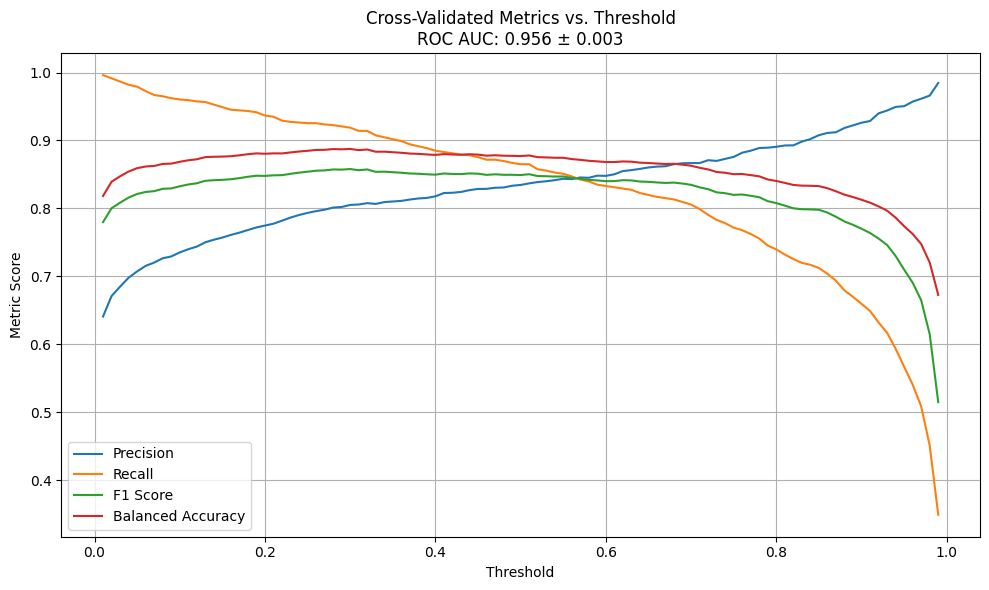

In [39]:
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    precision_score, recall_score, f1_score,
    balanced_accuracy_score, roc_auc_score
)
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import numpy as np

# --- Data ---
data = loop8_data
data_cols = [col for col in data.columns if 'COEFFICIENTS' not in col]
target_col = 'COEFFICIENTS'
X = data[data_cols].values
y = data[target_col].values.ravel()

# --- Thresholds ---
thresholds = np.linspace(0.01, 0.99, 99)
precisions = np.zeros_like(thresholds)
recalls = np.zeros_like(thresholds)
f1s = np.zeros_like(thresholds)
balanced_accuracies = np.zeros_like(thresholds)

# --- Track ROC AUC per fold
roc_aucs = []

# --- Stratified K-Fold CV ---
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for fold, (train_idx, test_idx) in enumerate(kf.split(X, y)):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    # --- Scaling (fit on train only, transform both train/test) ---
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # --- Model training ---
    model = XGBClassifier(eval_metric='logloss')
    model.fit(X_train, y_train)

    y_scores = model.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, y_scores)
    roc_aucs.append(auc)
    print(f"Fold {fold+1} ROC AUC: {auc:.3f}")

    for i, t in enumerate(thresholds):
        y_pred = (y_scores >= t).astype(int)
        precisions[i] += precision_score(y_test, y_pred, zero_division=0)
        recalls[i] += recall_score(y_test, y_pred)
        f1s[i] += f1_score(y_test, y_pred)
        balanced_accuracies[i] += balanced_accuracy_score(y_test, y_pred)

# --- Average metrics across folds ---
n_folds = kf.get_n_splits()
precisions /= n_folds
recalls /= n_folds
f1s /= n_folds
balanced_accuracies /= n_folds

# --- Report AUC ---
mean_auc = np.mean(roc_aucs)
std_auc = np.std(roc_aucs)
print(f"\nAverage ROC AUC: {mean_auc:.3f} ± {std_auc:.3f}")

# --- Plot ---
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precisions, label="Precision")
plt.plot(thresholds, recalls, label="Recall")
plt.plot(thresholds, f1s, label="F1 Score")
plt.plot(thresholds, balanced_accuracies, label="Balanced Accuracy")

plt.xlabel("Threshold")
plt.ylabel("Metric Score")
plt.title(f"Cross-Validated Metrics vs. Threshold\nROC AUC: {mean_auc:.3f} ± {std_auc:.3f}")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Fold 1 ROC AUC: 0.970
Fold 2 ROC AUC: 0.971
Fold 3 ROC AUC: 0.970
Fold 4 ROC AUC: 0.971
Fold 5 ROC AUC: 0.968

Average ROC AUC: 0.970 ± 0.001


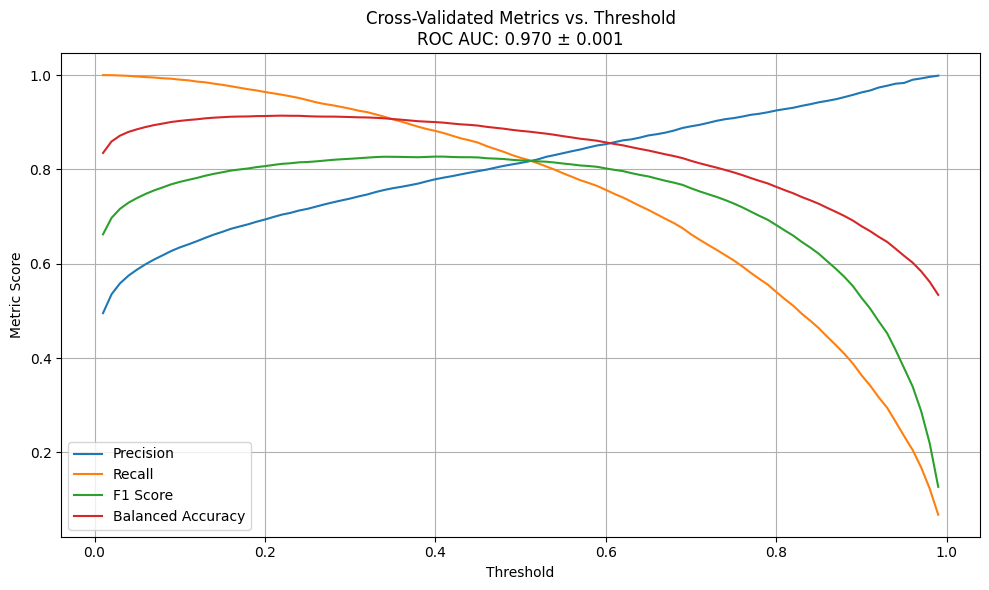

In [40]:
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    precision_score, recall_score, f1_score,
    balanced_accuracy_score, roc_auc_score
)
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import numpy as np

# --- Data ---
data = loop9_data
data_cols = [col for col in data.columns if 'COEFFICIENTS' not in col]
target_col = 'COEFFICIENTS'
X = data[data_cols].values
y = data[target_col].values.ravel()

# --- Thresholds ---
thresholds = np.linspace(0.01, 0.99, 99)
precisions = np.zeros_like(thresholds)
recalls = np.zeros_like(thresholds)
f1s = np.zeros_like(thresholds)
balanced_accuracies = np.zeros_like(thresholds)

# --- Track ROC AUC per fold
roc_aucs = []

# --- Stratified K-Fold CV ---
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for fold, (train_idx, test_idx) in enumerate(kf.split(X, y)):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    # --- Scaling (fit on train only, transform both train/test) ---
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # --- Model training ---
    model = XGBClassifier(eval_metric='logloss')
    model.fit(X_train, y_train)

    y_scores = model.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, y_scores)
    roc_aucs.append(auc)
    print(f"Fold {fold+1} ROC AUC: {auc:.3f}")

    for i, t in enumerate(thresholds):
        y_pred = (y_scores >= t).astype(int)
        precisions[i] += precision_score(y_test, y_pred, zero_division=0)
        recalls[i] += recall_score(y_test, y_pred)
        f1s[i] += f1_score(y_test, y_pred)
        balanced_accuracies[i] += balanced_accuracy_score(y_test, y_pred)

# --- Average metrics across folds ---
n_folds = kf.get_n_splits()
precisions /= n_folds
recalls /= n_folds
f1s /= n_folds
balanced_accuracies /= n_folds

# --- Report AUC ---
mean_auc = np.mean(roc_aucs)
std_auc = np.std(roc_aucs)
print(f"\nAverage ROC AUC: {mean_auc:.3f} ± {std_auc:.3f}")

# --- Plot ---
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precisions, label="Precision")
plt.plot(thresholds, recalls, label="Recall")
plt.plot(thresholds, f1s, label="F1 Score")
plt.plot(thresholds, balanced_accuracies, label="Balanced Accuracy")

plt.xlabel("Threshold")
plt.ylabel("Metric Score")
plt.title(f"Cross-Validated Metrics vs. Threshold\nROC AUC: {mean_auc:.3f} ± {std_auc:.3f}")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Fold 1 ROC AUC: 0.944
Fold 2 ROC AUC: 0.945
Fold 3 ROC AUC: 0.943
Fold 4 ROC AUC: 0.945
Fold 5 ROC AUC: 0.946

Average ROC AUC: 0.945 ± 0.001


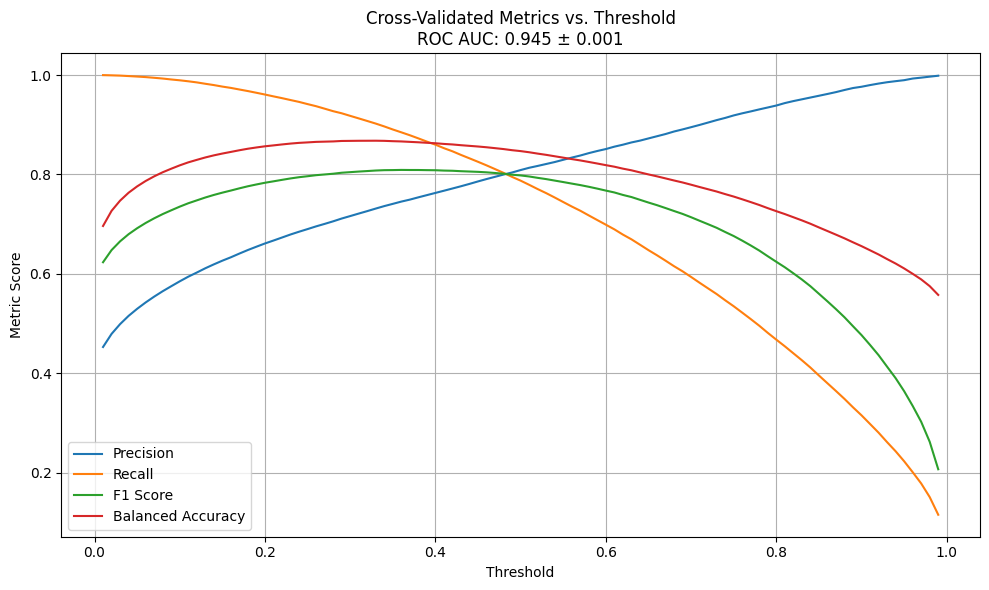

In [9]:
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    precision_score, recall_score, f1_score,
    balanced_accuracy_score, roc_auc_score
)
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import numpy as np

# --- Data ---
data = loop10_data
data_cols = [col for col in data.columns if 'COEFFICIENTS' not in col]
target_col = 'COEFFICIENTS'
X = data[data_cols].values
y = data[target_col].values.ravel()

# --- Thresholds ---
thresholds = np.linspace(0.01, 0.99, 99)
precisions = np.zeros_like(thresholds)
recalls = np.zeros_like(thresholds)
f1s = np.zeros_like(thresholds)
balanced_accuracies = np.zeros_like(thresholds)

# --- Track ROC AUC per fold
roc_aucs = []

# --- Stratified K-Fold CV ---
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for fold, (train_idx, test_idx) in enumerate(kf.split(X, y)):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    # --- Scaling (fit on train only, transform both train/test) ---
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # --- Model training ---
    model = XGBClassifier(eval_metric='logloss')
    model.fit(X_train, y_train)

    y_scores = model.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, y_scores)
    roc_aucs.append(auc)
    print(f"Fold {fold+1} ROC AUC: {auc:.3f}")

    for i, t in enumerate(thresholds):
        y_pred = (y_scores >= t).astype(int)
        precisions[i] += precision_score(y_test, y_pred, zero_division=0)
        recalls[i] += recall_score(y_test, y_pred)
        f1s[i] += f1_score(y_test, y_pred)
        balanced_accuracies[i] += balanced_accuracy_score(y_test, y_pred)

# --- Average metrics across folds ---
n_folds = kf.get_n_splits()
precisions /= n_folds
recalls /= n_folds
f1s /= n_folds
balanced_accuracies /= n_folds

# --- Report AUC ---
mean_auc = np.mean(roc_aucs)
std_auc = np.std(roc_aucs)
print(f"\nAverage ROC AUC: {mean_auc:.3f} ± {std_auc:.3f}")

# --- Plot ---
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precisions, label="Precision")
plt.plot(thresholds, recalls, label="Recall")
plt.plot(thresholds, f1s, label="F1 Score")
plt.plot(thresholds, balanced_accuracies, label="Balanced Accuracy")

plt.xlabel("Threshold")
plt.ylabel("Metric Score")
plt.title(f"Cross-Validated Metrics vs. Threshold\nROC AUC: {mean_auc:.3f} ± {std_auc:.3f}")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


/opt/miniconda3/envs/torch-env/lib/python3.10/site-packages/sklearn/utils/extmath.py:1144: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/opt/miniconda3/envs/torch-env/lib/python3.10/site-packages/sklearn/utils/extmath.py:1149: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/opt/miniconda3/envs/torch-env/lib/python3.10/site-packages/sklearn/utils/extmath.py:1169: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Fold 1 ROC AUC: 0.919


/opt/miniconda3/envs/torch-env/lib/python3.10/site-packages/sklearn/utils/extmath.py:1144: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/opt/miniconda3/envs/torch-env/lib/python3.10/site-packages/sklearn/utils/extmath.py:1149: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/opt/miniconda3/envs/torch-env/lib/python3.10/site-packages/sklearn/utils/extmath.py:1169: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Fold 2 ROC AUC: 0.920


/opt/miniconda3/envs/torch-env/lib/python3.10/site-packages/sklearn/utils/extmath.py:1144: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/opt/miniconda3/envs/torch-env/lib/python3.10/site-packages/sklearn/utils/extmath.py:1149: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/opt/miniconda3/envs/torch-env/lib/python3.10/site-packages/sklearn/utils/extmath.py:1169: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Fold 3 ROC AUC: 0.920


/opt/miniconda3/envs/torch-env/lib/python3.10/site-packages/sklearn/utils/extmath.py:1144: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/opt/miniconda3/envs/torch-env/lib/python3.10/site-packages/sklearn/utils/extmath.py:1149: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/opt/miniconda3/envs/torch-env/lib/python3.10/site-packages/sklearn/utils/extmath.py:1169: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Fold 4 ROC AUC: 0.918


/opt/miniconda3/envs/torch-env/lib/python3.10/site-packages/sklearn/utils/extmath.py:1144: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/opt/miniconda3/envs/torch-env/lib/python3.10/site-packages/sklearn/utils/extmath.py:1149: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/opt/miniconda3/envs/torch-env/lib/python3.10/site-packages/sklearn/utils/extmath.py:1169: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Fold 5 ROC AUC: 0.919

Average ROC AUC: 0.919 ± 0.000


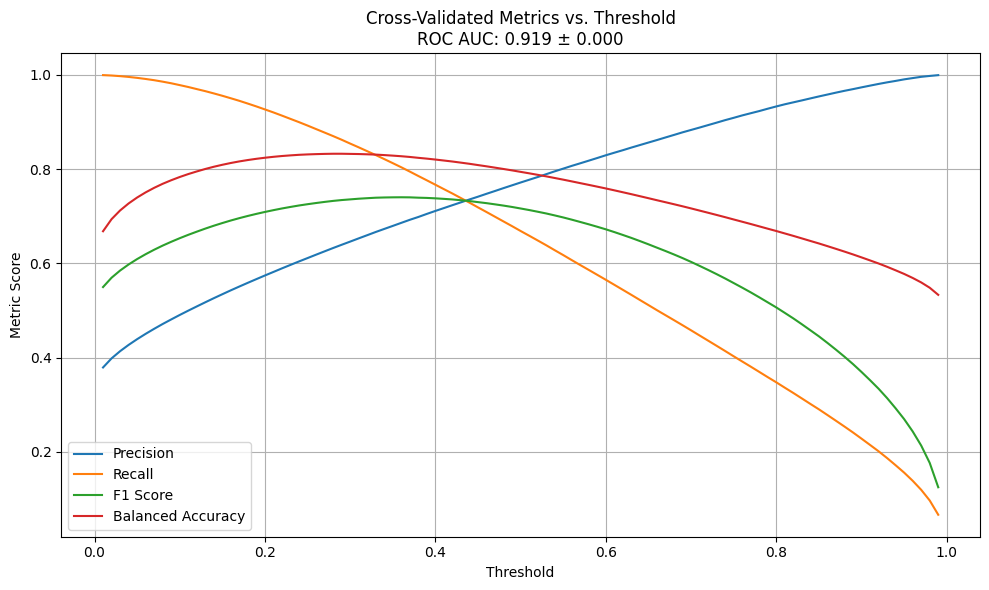

In [86]:
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    precision_score, recall_score, f1_score,
    balanced_accuracy_score, roc_auc_score
)
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import numpy as np

# --- Data ---
data = loop11_data
data_cols = [col for col in data.columns if 'COEFFICIENTS' not in col]
target_col = 'COEFFICIENTS'
X = data[data_cols].values
y = data[target_col].values.ravel()

# --- Thresholds ---
thresholds = np.linspace(0.01, 0.99, 99)
precisions = np.zeros_like(thresholds)
recalls = np.zeros_like(thresholds)
f1s = np.zeros_like(thresholds)
balanced_accuracies = np.zeros_like(thresholds)

# --- Track ROC AUC per fold
roc_aucs = []

# --- Stratified K-Fold CV ---
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for fold, (train_idx, test_idx) in enumerate(kf.split(X, y)):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    # --- Scaling (fit on train only, transform both train/test) ---
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # --- Model training ---
    model = XGBClassifier(eval_metric='logloss')
    model.fit(X_train, y_train)

    y_scores = model.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, y_scores)
    roc_aucs.append(auc)
    print(f"Fold {fold+1} ROC AUC: {auc:.3f}")

    for i, t in enumerate(thresholds):
        y_pred = (y_scores >= t).astype(int)
        precisions[i] += precision_score(y_test, y_pred, zero_division=0)
        recalls[i] += recall_score(y_test, y_pred)
        f1s[i] += f1_score(y_test, y_pred)
        balanced_accuracies[i] += balanced_accuracy_score(y_test, y_pred)

# --- Average metrics across folds ---
n_folds = kf.get_n_splits()
precisions /= n_folds
recalls /= n_folds
f1s /= n_folds
balanced_accuracies /= n_folds

# --- Report AUC ---
mean_auc = np.mean(roc_aucs)
std_auc = np.std(roc_aucs)
print(f"\nAverage ROC AUC: {mean_auc:.3f} ± {std_auc:.3f}")

# --- Plot ---
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precisions, label="Precision")
plt.plot(thresholds, recalls, label="Recall")
plt.plot(thresholds, f1s, label="F1 Score")
plt.plot(thresholds, balanced_accuracies, label="Balanced Accuracy")

plt.xlabel("Threshold")
plt.ylabel("Metric Score")
plt.title(f"Cross-Validated Metrics vs. Threshold\nROC AUC: {mean_auc:.3f} ± {std_auc:.3f}")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [41]:
#pairwise stratifications

loop7_data['loops'] = 7
loop8_data['loops'] = 8
loop9_data['loops'] = 9

In [42]:
all_loops = pd.concat([loop7_data, loop8_data, loop9_data], axis = 0)

Fold 1 ROC AUC (loop 10): 0.906
Fold 1 ROC AUC (loop 11): 0.919
Fold 2 ROC AUC (loop 10): 0.905
Fold 2 ROC AUC (loop 11): 0.919
Fold 3 ROC AUC (loop 10): 0.905
Fold 3 ROC AUC (loop 11): 0.918
Fold 4 ROC AUC (loop 10): 0.907
Fold 4 ROC AUC (loop 11): 0.918
Fold 5 ROC AUC (loop 10): 0.909
Fold 5 ROC AUC (loop 11): 0.918

Average ROC AUC for loop 10: 0.906 ± 0.002
Average ROC AUC for loop 11: 0.919 ± 0.000


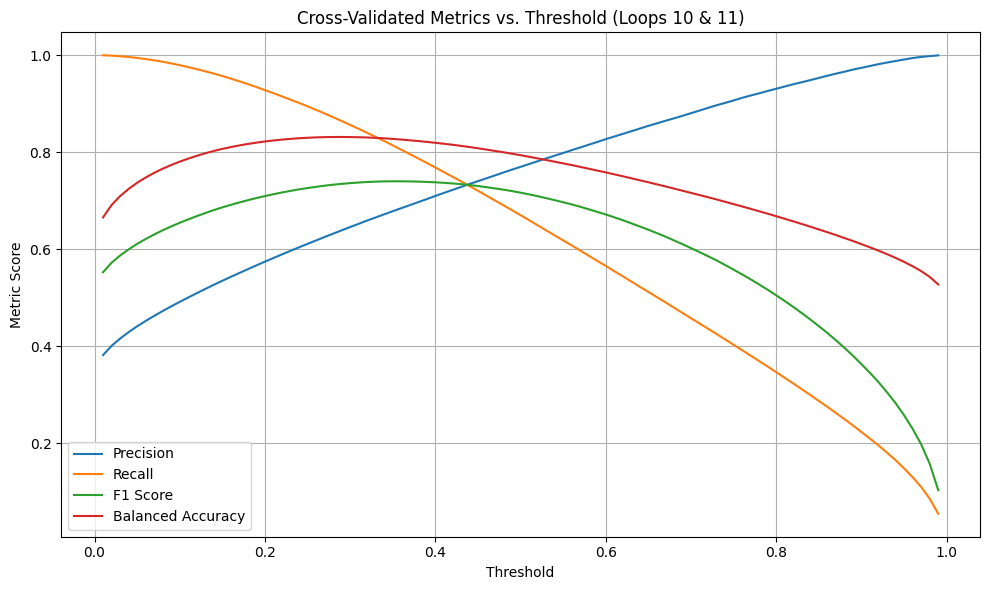

In [89]:
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, f1_score, balanced_accuracy_score, roc_auc_score
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import numpy as np

# --- Filter data: train/test only on loops 7 & 8 ---
data = all_loops[all_loops['loops'].isin([10,11])]

# --- Setup ---
data_cols = [col for col in data.columns if 'COEFFICIENTS' not in col]
target_col = 'COEFFICIENTS'
stratify_labels = data[target_col].astype(str) + "_" + data["loops"].astype(str)

X = data[data_cols].values
y = data[target_col].values.ravel()
loops = data["loops"].values  # to track per-test-loop performance

# --- Thresholds for precision/recall curves ---
thresholds = np.linspace(0.01, 0.99, 99)
precisions = np.zeros_like(thresholds)
recalls = np.zeros_like(thresholds)
f1s = np.zeros_like(thresholds)
balanced_accuracies = np.zeros_like(thresholds)

# --- Store ROC AUC per loop, per fold ---
loop7_aucs = []
loop8_aucs = []

# --- Cross-validation ---
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for fold, (train_idx, test_idx) in enumerate(kf.split(X, stratify_labels)):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    loop_test = loops[test_idx]

    # Optional: scaling
    # scaler = StandardScaler()
    # X_train = scaler.fit_transform(X_train)
    # X_test = scaler.transform(X_test)

    model = XGBClassifier(eval_metric='logloss')
    model.fit(X_train, y_train)
    y_scores = model.predict_proba(X_test)[:, 1]

    # --- AUCs per loop value ---
    for loop_id, auc_list in [(10, loop7_aucs), (11, loop8_aucs)]:
        mask = loop_test == loop_id
        if mask.sum() > 0:
            auc = roc_auc_score(y_test[mask], y_scores[mask])
            auc_list.append(auc)
            print(f"Fold {fold+1} ROC AUC (loop {loop_id}): {auc:.3f}")
        else:
            print(f"Fold {fold+1} has no samples for loop {loop_id}")

    # --- Threshold-dependent metrics ---
    for i, t in enumerate(thresholds):
        y_pred = (y_scores >= t).astype(int)
        precisions[i] += precision_score(y_test, y_pred, zero_division=0)
        recalls[i] += recall_score(y_test, y_pred)
        f1s[i] += f1_score(y_test, y_pred)
        balanced_accuracies[i] += balanced_accuracy_score(y_test, y_pred)

# --- Average threshold metrics ---
n_folds = kf.get_n_splits()
precisions /= n_folds
recalls /= n_folds
f1s /= n_folds
balanced_accuracies /= n_folds

# --- Report average AUCs ---
print(f"\nAverage ROC AUC for loop 10: {np.mean(loop7_aucs):.3f} ± {np.std(loop7_aucs):.3f}")
print(f"Average ROC AUC for loop 11: {np.mean(loop8_aucs):.3f} ± {np.std(loop8_aucs):.3f}")

# --- Plot metrics vs threshold ---
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precisions, label="Precision")
plt.plot(thresholds, recalls, label="Recall")
plt.plot(thresholds, f1s, label="F1 Score")
plt.plot(thresholds, balanced_accuracies, label="Balanced Accuracy")

plt.xlabel("Threshold")
plt.ylabel("Metric Score")
plt.title("Cross-Validated Metrics vs. Threshold (Loops 10 & 11)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Fold 1 ROC AUC (loop 7): 0.947
Fold 1 ROC AUC (loop 8): 0.952
Fold 2 ROC AUC (loop 7): 0.959
Fold 2 ROC AUC (loop 8): 0.956
Fold 3 ROC AUC (loop 7): 0.962
Fold 3 ROC AUC (loop 8): 0.959
Fold 4 ROC AUC (loop 7): 0.962
Fold 4 ROC AUC (loop 8): 0.954
Fold 5 ROC AUC (loop 7): 0.958
Fold 5 ROC AUC (loop 8): 0.967

Average ROC AUC for loop 7: 0.958 ± 0.006
Average ROC AUC for loop 8: 0.958 ± 0.005


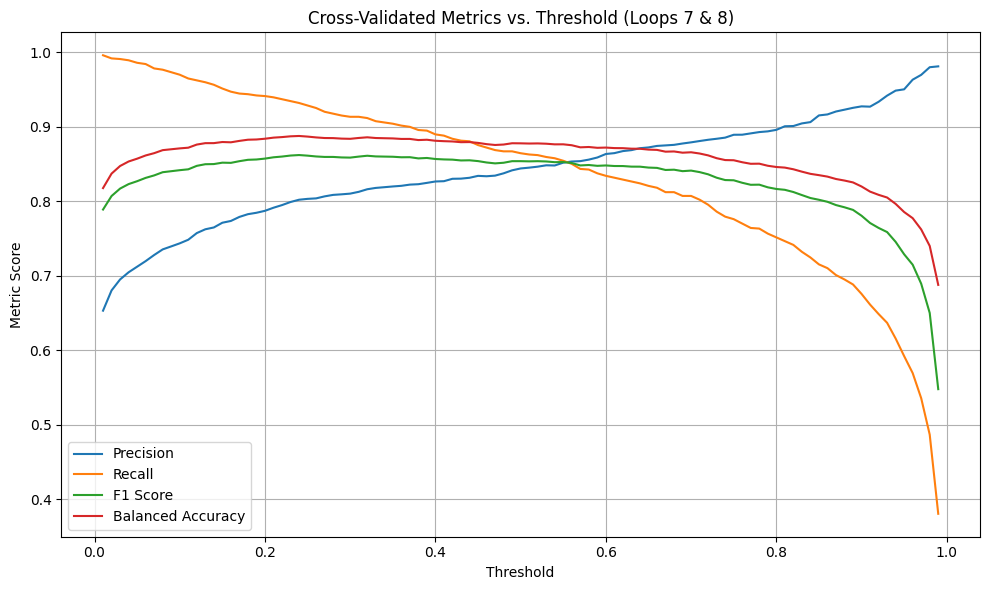

In [43]:
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, f1_score, balanced_accuracy_score, roc_auc_score
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import numpy as np

# --- Filter data: train/test only on loops 7 & 8 ---
data = all_loops[all_loops['loops'].isin([7, 8])]

# --- Setup ---
data_cols = [col for col in data.columns if 'COEFFICIENTS' not in col]
target_col = 'COEFFICIENTS'
stratify_labels = data[target_col].astype(str) + "_" + data["loops"].astype(str)

X = data[data_cols].values
y = data[target_col].values.ravel()
loops = data["loops"].values  # to track per-test-loop performance

# --- Thresholds for precision/recall curves ---
thresholds = np.linspace(0.01, 0.99, 99)
precisions = np.zeros_like(thresholds)
recalls = np.zeros_like(thresholds)
f1s = np.zeros_like(thresholds)
balanced_accuracies = np.zeros_like(thresholds)

# --- Store ROC AUC per loop, per fold ---
loop7_aucs = []
loop8_aucs = []

# --- Cross-validation ---
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for fold, (train_idx, test_idx) in enumerate(kf.split(X, stratify_labels)):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    loop_test = loops[test_idx]

    # Optional: scaling
    # scaler = StandardScaler()
    # X_train = scaler.fit_transform(X_train)
    # X_test = scaler.transform(X_test)

    model = XGBClassifier(eval_metric='logloss')
    model.fit(X_train, y_train)
    y_scores = model.predict_proba(X_test)[:, 1]

    # --- AUCs per loop value ---
    for loop_id, auc_list in [(7, loop7_aucs), (8, loop8_aucs)]:
        mask = loop_test == loop_id
        if mask.sum() > 0:
            auc = roc_auc_score(y_test[mask], y_scores[mask])
            auc_list.append(auc)
            print(f"Fold {fold+1} ROC AUC (loop {loop_id}): {auc:.3f}")
        else:
            print(f"Fold {fold+1} has no samples for loop {loop_id}")

    # --- Threshold-dependent metrics ---
    for i, t in enumerate(thresholds):
        y_pred = (y_scores >= t).astype(int)
        precisions[i] += precision_score(y_test, y_pred, zero_division=0)
        recalls[i] += recall_score(y_test, y_pred)
        f1s[i] += f1_score(y_test, y_pred)
        balanced_accuracies[i] += balanced_accuracy_score(y_test, y_pred)

# --- Average threshold metrics ---
n_folds = kf.get_n_splits()
precisions /= n_folds
recalls /= n_folds
f1s /= n_folds
balanced_accuracies /= n_folds

# --- Report average AUCs ---
print(f"\nAverage ROC AUC for loop 7: {np.mean(loop7_aucs):.3f} ± {np.std(loop7_aucs):.3f}")
print(f"Average ROC AUC for loop 8: {np.mean(loop8_aucs):.3f} ± {np.std(loop8_aucs):.3f}")

# --- Plot metrics vs threshold ---
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precisions, label="Precision")
plt.plot(thresholds, recalls, label="Recall")
plt.plot(thresholds, f1s, label="F1 Score")
plt.plot(thresholds, balanced_accuracies, label="Balanced Accuracy")

plt.xlabel("Threshold")
plt.ylabel("Metric Score")
plt.title("Cross-Validated Metrics vs. Threshold (Loops 7 & 8)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Fold 1 ROC AUC (loop 8): 0.868
Fold 1 ROC AUC (loop 9): 0.899
Fold 2 ROC AUC (loop 8): 0.887
Fold 2 ROC AUC (loop 9): 0.894
Fold 3 ROC AUC (loop 8): 0.883
Fold 3 ROC AUC (loop 9): 0.906
Fold 4 ROC AUC (loop 8): 0.882
Fold 4 ROC AUC (loop 9): 0.898
Fold 5 ROC AUC (loop 8): 0.876
Fold 5 ROC AUC (loop 9): 0.909

Average ROC AUC for loop 8: 0.879 ± 0.007
Average ROC AUC for loop 9: 0.901 ± 0.006


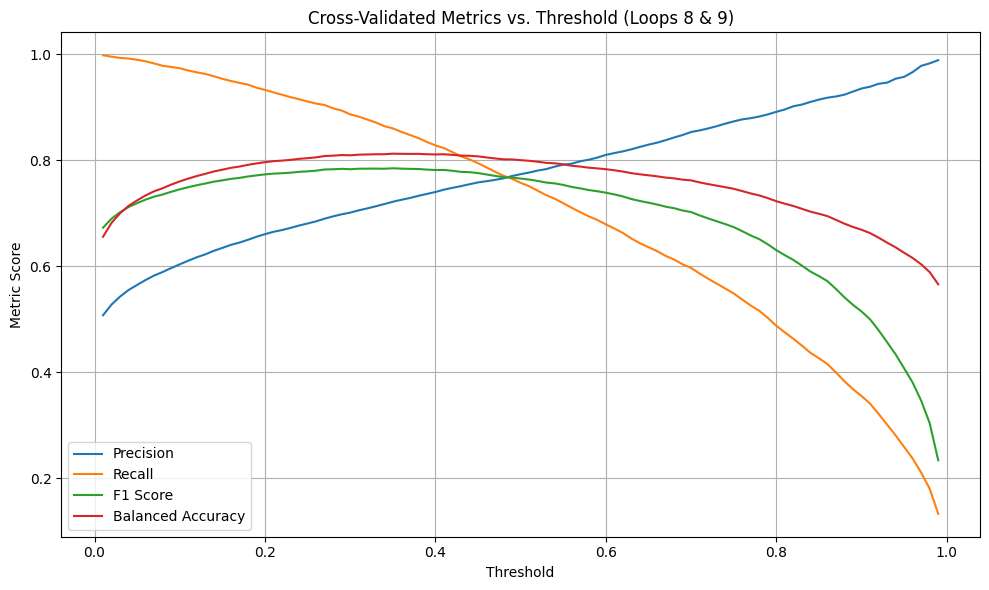

In [46]:
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, f1_score, balanced_accuracy_score, roc_auc_score
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import numpy as np

# --- Filter data: train/test only on loops 7 & 8 ---
data = all_loops[all_loops['loops'].isin([8,9])]

# --- Setup ---
data_cols = [col for col in data.columns if 'COEFFICIENTS' not in col]
target_col = 'COEFFICIENTS'
stratify_labels = data[target_col].astype(str) + "_" + data["loops"].astype(str)

X = data[data_cols].values
y = data[target_col].values.ravel()
loops = data["loops"].values  # to track per-test-loop performance

# --- Thresholds for precision/recall curves ---
thresholds = np.linspace(0.01, 0.99, 99)
precisions = np.zeros_like(thresholds)
recalls = np.zeros_like(thresholds)
f1s = np.zeros_like(thresholds)
balanced_accuracies = np.zeros_like(thresholds)

# --- Store ROC AUC per loop, per fold ---
loop8_aucs = []
loop9_aucs = []

# --- Cross-validation ---
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for fold, (train_idx, test_idx) in enumerate(kf.split(X, stratify_labels)):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    loop_test = loops[test_idx]

    # Optional: scaling
    # scaler = StandardScaler()
    # X_train = scaler.fit_transform(X_train)
    # X_test = scaler.transform(X_test)

    model = XGBClassifier(eval_metric='logloss')
    model.fit(X_train, y_train)
    y_scores = model.predict_proba(X_test)[:, 1]

    # --- AUCs per loop value ---
    for loop_id, auc_list in [(8, loop8_aucs), (9, loop9_aucs)]:
        mask = loop_test == loop_id
        if mask.sum() > 0:
            auc = roc_auc_score(y_test[mask], y_scores[mask])
            auc_list.append(auc)
            print(f"Fold {fold+1} ROC AUC (loop {loop_id}): {auc:.3f}")
        else:
            print(f"Fold {fold+1} has no samples for loop {loop_id}")

    # --- Threshold-dependent metrics ---
    for i, t in enumerate(thresholds):
        y_pred = (y_scores >= t).astype(int)
        precisions[i] += precision_score(y_test, y_pred, zero_division=0)
        recalls[i] += recall_score(y_test, y_pred)
        f1s[i] += f1_score(y_test, y_pred)
        balanced_accuracies[i] += balanced_accuracy_score(y_test, y_pred)

# --- Average threshold metrics ---
n_folds = kf.get_n_splits()
precisions /= n_folds
recalls /= n_folds
f1s /= n_folds
balanced_accuracies /= n_folds

# --- Report average AUCs ---
print(f"\nAverage ROC AUC for loop 8: {np.mean(loop8_aucs):.3f} ± {np.std(loop8_aucs):.3f}")
print(f"Average ROC AUC for loop 9: {np.mean(loop9_aucs):.3f} ± {np.std(loop9_aucs):.3f}")

# --- Plot metrics vs threshold ---
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precisions, label="Precision")
plt.plot(thresholds, recalls, label="Recall")
plt.plot(thresholds, f1s, label="F1 Score")
plt.plot(thresholds, balanced_accuracies, label="Balanced Accuracy")

plt.xlabel("Threshold")
plt.ylabel("Metric Score")
plt.title("Cross-Validated Metrics vs. Threshold (Loops 8 & 9)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Fold 1 ROC AUC (loop 9): 0.902
Fold 1 ROC AUC (loop 10): 0.916
Fold 2 ROC AUC (loop 9): 0.895
Fold 2 ROC AUC (loop 10): 0.914
Fold 3 ROC AUC (loop 9): 0.896
Fold 3 ROC AUC (loop 10): 0.913
Fold 4 ROC AUC (loop 9): 0.912
Fold 4 ROC AUC (loop 10): 0.914
Fold 5 ROC AUC (loop 9): 0.905
Fold 5 ROC AUC (loop 10): 0.916

Average ROC AUC for loop 9: 0.902 ± 0.006
Average ROC AUC for loop 10: 0.914 ± 0.001


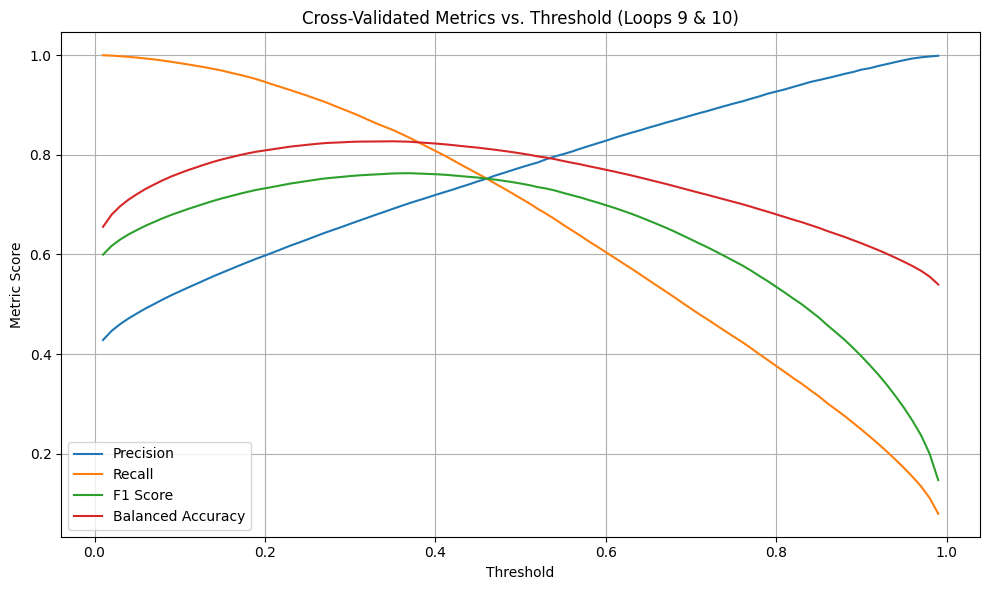

In [48]:
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, f1_score, balanced_accuracy_score, roc_auc_score
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import numpy as np

# --- Filter data: train/test only on loops 7 & 8 ---
data = all_loops[all_loops['loops'].isin([9,10])]

# --- Setup ---
data_cols = [col for col in data.columns if 'COEFFICIENTS' not in col]
target_col = 'COEFFICIENTS'
stratify_labels = data[target_col].astype(str) + "_" + data["loops"].astype(str)

X = data[data_cols].values
y = data[target_col].values.ravel()
loops = data["loops"].values  # to track per-test-loop performance

# --- Thresholds for precision/recall curves ---
thresholds = np.linspace(0.01, 0.99, 99)
precisions = np.zeros_like(thresholds)
recalls = np.zeros_like(thresholds)
f1s = np.zeros_like(thresholds)
balanced_accuracies = np.zeros_like(thresholds)

# --- Store ROC AUC per loop, per fold ---
loop8_aucs = []
loop9_aucs = []

# --- Cross-validation ---
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for fold, (train_idx, test_idx) in enumerate(kf.split(X, stratify_labels)):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    loop_test = loops[test_idx]

    # Optional: scaling
    # scaler = StandardScaler()
    # X_train = scaler.fit_transform(X_train)
    # X_test = scaler.transform(X_test)

    model = XGBClassifier(eval_metric='logloss')
    model.fit(X_train, y_train)
    y_scores = model.predict_proba(X_test)[:, 1]

    # --- AUCs per loop value ---
    for loop_id, auc_list in [(9, loop8_aucs), (10, loop9_aucs)]:
        mask = loop_test == loop_id
        if mask.sum() > 0:
            auc = roc_auc_score(y_test[mask], y_scores[mask])
            auc_list.append(auc)
            print(f"Fold {fold+1} ROC AUC (loop {loop_id}): {auc:.3f}")
        else:
            print(f"Fold {fold+1} has no samples for loop {loop_id}")

    # --- Threshold-dependent metrics ---
    for i, t in enumerate(thresholds):
        y_pred = (y_scores >= t).astype(int)
        precisions[i] += precision_score(y_test, y_pred, zero_division=0)
        recalls[i] += recall_score(y_test, y_pred)
        f1s[i] += f1_score(y_test, y_pred)
        balanced_accuracies[i] += balanced_accuracy_score(y_test, y_pred)

# --- Average threshold metrics ---
n_folds = kf.get_n_splits()
precisions /= n_folds
recalls /= n_folds
f1s /= n_folds
balanced_accuracies /= n_folds

# --- Report average AUCs ---
print(f"\nAverage ROC AUC for loop 9: {np.mean(loop8_aucs):.3f} ± {np.std(loop8_aucs):.3f}")
print(f"Average ROC AUC for loop 10: {np.mean(loop9_aucs):.3f} ± {np.std(loop9_aucs):.3f}")

# --- Plot metrics vs threshold ---
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precisions, label="Precision")
plt.plot(thresholds, recalls, label="Recall")
plt.plot(thresholds, f1s, label="F1 Score")
plt.plot(thresholds, balanced_accuracies, label="Balanced Accuracy")

plt.xlabel("Threshold")
plt.ylabel("Metric Score")
plt.title("Cross-Validated Metrics vs. Threshold (Loops 9 & 10)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Fold 1 ROC AUC (loop 8): 0.850
Fold 1 ROC AUC (loop 10): 0.917
Fold 2 ROC AUC (loop 8): 0.856
Fold 2 ROC AUC (loop 10): 0.915
Fold 3 ROC AUC (loop 8): 0.864
Fold 3 ROC AUC (loop 10): 0.914
Fold 4 ROC AUC (loop 8): 0.872
Fold 4 ROC AUC (loop 10): 0.917
Fold 5 ROC AUC (loop 8): 0.845
Fold 5 ROC AUC (loop 10): 0.914

Average ROC AUC for loop 8: 0.858 ± 0.010
Average ROC AUC for loop 10: 0.915 ± 0.001


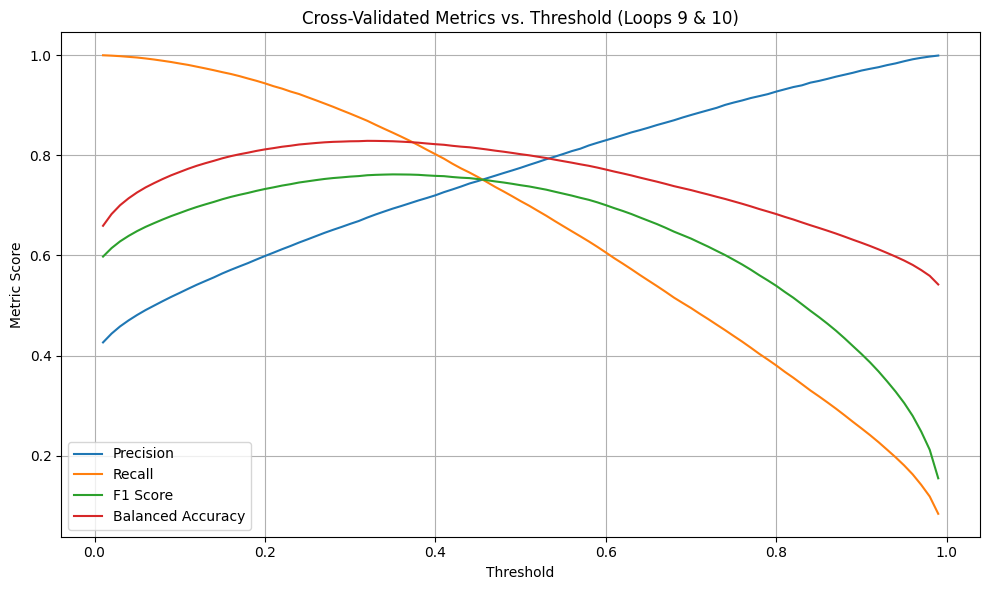

In [49]:
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, f1_score, balanced_accuracy_score, roc_auc_score
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import numpy as np

# --- Filter data: train/test only on loops 7 & 8 ---
data = all_loops[all_loops['loops'].isin([8,10])]

# --- Setup ---
data_cols = [col for col in data.columns if 'COEFFICIENTS' not in col]
target_col = 'COEFFICIENTS'
stratify_labels = data[target_col].astype(str) + "_" + data["loops"].astype(str)

X = data[data_cols].values
y = data[target_col].values.ravel()
loops = data["loops"].values  # to track per-test-loop performance

# --- Thresholds for precision/recall curves ---
thresholds = np.linspace(0.01, 0.99, 99)
precisions = np.zeros_like(thresholds)
recalls = np.zeros_like(thresholds)
f1s = np.zeros_like(thresholds)
balanced_accuracies = np.zeros_like(thresholds)

# --- Store ROC AUC per loop, per fold ---
loop8_aucs = []
loop9_aucs = []

# --- Cross-validation ---
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for fold, (train_idx, test_idx) in enumerate(kf.split(X, stratify_labels)):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    loop_test = loops[test_idx]

    # Optional: scaling
    # scaler = StandardScaler()
    # X_train = scaler.fit_transform(X_train)
    # X_test = scaler.transform(X_test)

    model = XGBClassifier(eval_metric='logloss')
    model.fit(X_train, y_train)
    y_scores = model.predict_proba(X_test)[:, 1]

    # --- AUCs per loop value ---
    for loop_id, auc_list in [(8, loop8_aucs), (10, loop9_aucs)]:
        mask = loop_test == loop_id
        if mask.sum() > 0:
            auc = roc_auc_score(y_test[mask], y_scores[mask])
            auc_list.append(auc)
            print(f"Fold {fold+1} ROC AUC (loop {loop_id}): {auc:.3f}")
        else:
            print(f"Fold {fold+1} has no samples for loop {loop_id}")

    # --- Threshold-dependent metrics ---
    for i, t in enumerate(thresholds):
        y_pred = (y_scores >= t).astype(int)
        precisions[i] += precision_score(y_test, y_pred, zero_division=0)
        recalls[i] += recall_score(y_test, y_pred)
        f1s[i] += f1_score(y_test, y_pred)
        balanced_accuracies[i] += balanced_accuracy_score(y_test, y_pred)

# --- Average threshold metrics ---
n_folds = kf.get_n_splits()
precisions /= n_folds
recalls /= n_folds
f1s /= n_folds
balanced_accuracies /= n_folds

# --- Report average AUCs ---
print(f"\nAverage ROC AUC for loop 8: {np.mean(loop8_aucs):.3f} ± {np.std(loop8_aucs):.3f}")
print(f"Average ROC AUC for loop 10: {np.mean(loop9_aucs):.3f} ± {np.std(loop9_aucs):.3f}")

# --- Plot metrics vs threshold ---
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precisions, label="Precision")
plt.plot(thresholds, recalls, label="Recall")
plt.plot(thresholds, f1s, label="F1 Score")
plt.plot(thresholds, balanced_accuracies, label="Balanced Accuracy")

plt.xlabel("Threshold")
plt.ylabel("Metric Score")
plt.title("Cross-Validated Metrics vs. Threshold (Loops 9 & 10)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Fold 1 ROC AUC (loop 9): 0.902
Fold 1 ROC AUC (loop 10): 0.916
Fold 2 ROC AUC (loop 9): 0.895
Fold 2 ROC AUC (loop 10): 0.914
Fold 3 ROC AUC (loop 9): 0.896
Fold 3 ROC AUC (loop 10): 0.913
Fold 4 ROC AUC (loop 9): 0.912
Fold 4 ROC AUC (loop 10): 0.914
Fold 5 ROC AUC (loop 9): 0.905
Fold 5 ROC AUC (loop 10): 0.916

Average ROC AUC for loop 9: 0.902 ± 0.006
Average ROC AUC for loop 10: 0.914 ± 0.001


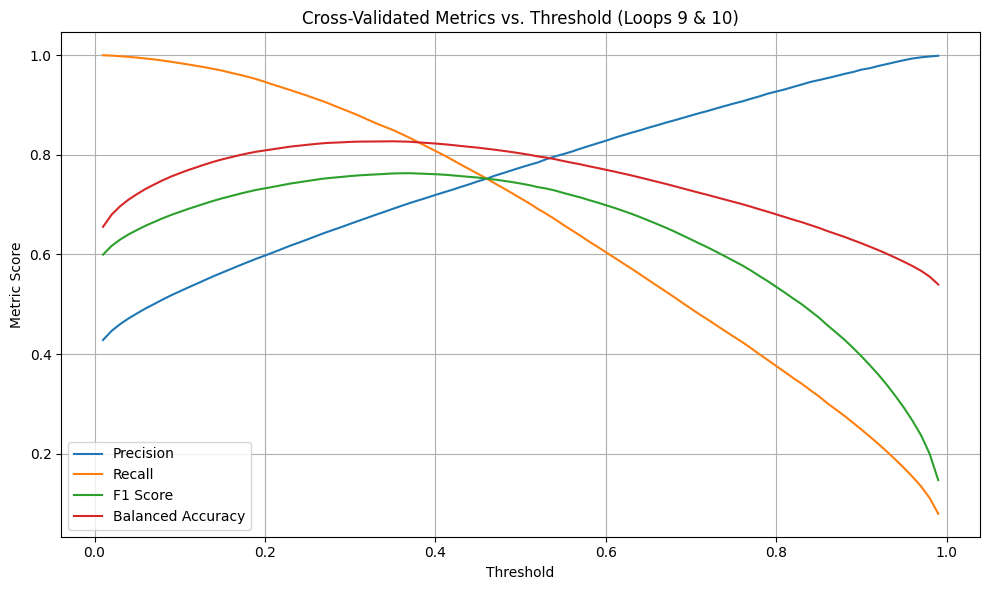

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, f1_score, balanced_accuracy_score, roc_auc_score
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import numpy as np

# --- Filter data: train/test only on loops 7 & 8 ---
data = all_loops[all_loops['loops'].isin([9,10])]

# --- Setup ---
data_cols = [col for col in data.columns if 'COEFFICIENTS' not in col]
target_col = 'COEFFICIENTS'
stratify_labels = data[target_col].astype(str) + "_" + data["loops"].astype(str)

X = data[data_cols].values
y = data[target_col].values.ravel()
loops = data["loops"].values  # to track per-test-loop performance

# --- Thresholds for precision/recall curves ---
thresholds = np.linspace(0.01, 0.99, 99)
precisions = np.zeros_like(thresholds)
recalls = np.zeros_like(thresholds)
f1s = np.zeros_like(thresholds)
balanced_accuracies = np.zeros_like(thresholds)

# --- Store ROC AUC per loop, per fold ---
loop8_aucs = []
loop9_aucs = []

# --- Cross-validation ---
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for fold, (train_idx, test_idx) in enumerate(kf.split(X, stratify_labels)):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    loop_test = loops[test_idx]

    # Optional: scaling
    # scaler = StandardScaler()
    # X_train = scaler.fit_transform(X_train)
    # X_test = scaler.transform(X_test)

    model = XGBClassifier(eval_metric='logloss')
    model.fit(X_train, y_train)
    y_scores = model.predict_proba(X_test)[:, 1]

    # --- AUCs per loop value ---
    for loop_id, auc_list in [(9, loop8_aucs), (10, loop9_aucs)]:
        mask = loop_test == loop_id
        if mask.sum() > 0:
            auc = roc_auc_score(y_test[mask], y_scores[mask])
            auc_list.append(auc)
            print(f"Fold {fold+1} ROC AUC (loop {loop_id}): {auc:.3f}")
        else:
            print(f"Fold {fold+1} has no samples for loop {loop_id}")

    # --- Threshold-dependent metrics ---
    for i, t in enumerate(thresholds):
        y_pred = (y_scores >= t).astype(int)
        precisions[i] += precision_score(y_test, y_pred, zero_division=0)
        recalls[i] += recall_score(y_test, y_pred)
        f1s[i] += f1_score(y_test, y_pred)
        balanced_accuracies[i] += balanced_accuracy_score(y_test, y_pred)

# --- Average threshold metrics ---
n_folds = kf.get_n_splits()
precisions /= n_folds
recalls /= n_folds
f1s /= n_folds
balanced_accuracies /= n_folds

# --- Report average AUCs ---
print(f"\nAverage ROC AUC for loop 9: {np.mean(loop8_aucs):.3f} ± {np.std(loop8_aucs):.3f}")
print(f"Average ROC AUC for loop 10: {np.mean(loop9_aucs):.3f} ± {np.std(loop9_aucs):.3f}")

# --- Plot metrics vs threshold ---
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precisions, label="Precision")
plt.plot(thresholds, recalls, label="Recall")
plt.plot(thresholds, f1s, label="F1 Score")
plt.plot(thresholds, balanced_accuracies, label="Balanced Accuracy")

plt.xlabel("Threshold")
plt.ylabel("Metric Score")
plt.title("Cross-Validated Metrics vs. Threshold (Loops 9 & 10)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Fold 1 ROC AUC (loop 7): 0.756
Fold 1 ROC AUC (loop 10): 0.918
Fold 2 ROC AUC (loop 7): 0.736
Fold 2 ROC AUC (loop 10): 0.917
Fold 3 ROC AUC (loop 7): 0.774
Fold 3 ROC AUC (loop 10): 0.915
Fold 4 ROC AUC (loop 7): 0.810
Fold 4 ROC AUC (loop 10): 0.916
Fold 5 ROC AUC (loop 7): 0.662
Fold 5 ROC AUC (loop 10): 0.915

Average ROC AUC for loop 7: 0.747 ± 0.049
Average ROC AUC for loop 10: 0.916 ± 0.001


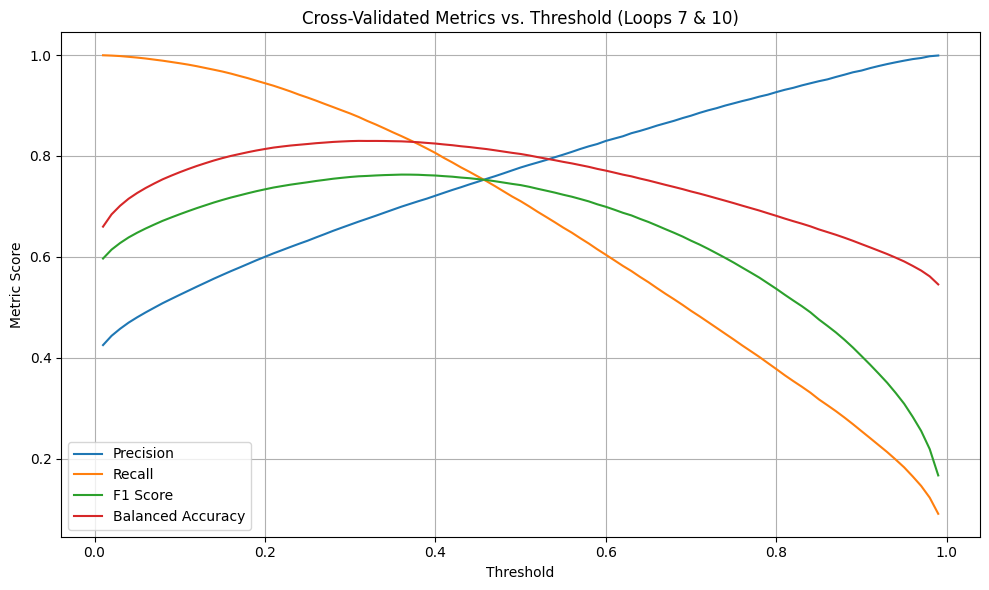

In [51]:
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, f1_score, balanced_accuracy_score, roc_auc_score
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import numpy as np

# --- Filter data: train/test only on loops 7 & 8 ---
data = all_loops[all_loops['loops'].isin([7,10])]

# --- Setup ---
data_cols = [col for col in data.columns if 'COEFFICIENTS' not in col]
target_col = 'COEFFICIENTS'
stratify_labels = data[target_col].astype(str) + "_" + data["loops"].astype(str)

X = data[data_cols].values
y = data[target_col].values.ravel()
loops = data["loops"].values  # to track per-test-loop performance

# --- Thresholds for precision/recall curves ---
thresholds = np.linspace(0.01, 0.99, 99)
precisions = np.zeros_like(thresholds)
recalls = np.zeros_like(thresholds)
f1s = np.zeros_like(thresholds)
balanced_accuracies = np.zeros_like(thresholds)

# --- Store ROC AUC per loop, per fold ---
loop8_aucs = []
loop9_aucs = []

# --- Cross-validation ---
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for fold, (train_idx, test_idx) in enumerate(kf.split(X, stratify_labels)):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    loop_test = loops[test_idx]

    # Optional: scaling
    # scaler = StandardScaler()
    # X_train = scaler.fit_transform(X_train)
    # X_test = scaler.transform(X_test)

    model = XGBClassifier(eval_metric='logloss')
    model.fit(X_train, y_train)
    y_scores = model.predict_proba(X_test)[:, 1]

    # --- AUCs per loop value ---
    for loop_id, auc_list in [(7, loop8_aucs), (10, loop9_aucs)]:
        mask = loop_test == loop_id
        if mask.sum() > 0:
            auc = roc_auc_score(y_test[mask], y_scores[mask])
            auc_list.append(auc)
            print(f"Fold {fold+1} ROC AUC (loop {loop_id}): {auc:.3f}")
        else:
            print(f"Fold {fold+1} has no samples for loop {loop_id}")

    # --- Threshold-dependent metrics ---
    for i, t in enumerate(thresholds):
        y_pred = (y_scores >= t).astype(int)
        precisions[i] += precision_score(y_test, y_pred, zero_division=0)
        recalls[i] += recall_score(y_test, y_pred)
        f1s[i] += f1_score(y_test, y_pred)
        balanced_accuracies[i] += balanced_accuracy_score(y_test, y_pred)

# --- Average threshold metrics ---
n_folds = kf.get_n_splits()
precisions /= n_folds
recalls /= n_folds
f1s /= n_folds
balanced_accuracies /= n_folds

# --- Report average AUCs ---
print(f"\nAverage ROC AUC for loop 7: {np.mean(loop8_aucs):.3f} ± {np.std(loop8_aucs):.3f}")
print(f"Average ROC AUC for loop 10: {np.mean(loop9_aucs):.3f} ± {np.std(loop9_aucs):.3f}")

# --- Plot metrics vs threshold ---
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precisions, label="Precision")
plt.plot(thresholds, recalls, label="Recall")
plt.plot(thresholds, f1s, label="F1 Score")
plt.plot(thresholds, balanced_accuracies, label="Balanced Accuracy")

plt.xlabel("Threshold")
plt.ylabel("Metric Score")
plt.title("Cross-Validated Metrics vs. Threshold (Loops 7 & 10)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [16]:
# directionality

In [15]:
from sklearn.metrics import precision_score, recall_score, f1_score, balanced_accuracy_score, roc_auc_score
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import numpy as np

# --- Define loops to use ---
train_loops = [7]
test_loops = [8, 9, 10]

# --- Split data ---
train_data = all_loops[all_loops['loops'].isin(train_loops)]
test_data  = all_loops[all_loops['loops'].isin(test_loops)]

# --- Columns ---
target_col   = 'COEFFICIENTS'
# Use all columns except the target and the loop id as features
feature_cols = [c for c in all_loops.columns if c not in [target_col, 'loops']]

# --- Train data ---
X_train_full = train_data[feature_cols].values
y_train_full = train_data[target_col].values.ravel()

# --- Test data ---
X_test   = test_data[feature_cols].values
y_test   = test_data[target_col].values.ravel()
loop_test = test_data['loops'].values

# --- Train a single model on ALL training data ---
model = XGBClassifier(eval_metric='logloss', use_label_encoder=False)
model.fit(X_train_full, y_train_full)

# --- Predict on the combined test set ---
test_scores = model.predict_proba(X_test)[:, 1]

# --- AUC per test loop ---
per_loop_auc = {}
for loop_id in test_loops:
    mask = (loop_test == loop_id)
    if mask.sum() > 0:
        auc = roc_auc_score(y_test[mask], test_scores[mask])
        per_loop_auc[loop_id] = auc
        print(f"AUC (loop {loop_id}): {auc:.3f}")
    else:
        print(f"No samples for loop {loop_id} in test set")

# --- (Optional) AUC on the training data just for reference ---
train_scores = model.predict_proba(X_train_full)[:, 1]
train_auc = roc_auc_score(y_train_full, train_scores)
print(f"AUC (train loops {train_loops}): {train_auc:.3f}")

# --- Threshold sweep on the combined test set ---
thresholds = np.linspace(0.01, 0.99, 99)

precisions = []
recalls = []
f1s = []
balanced_accuracies = []

for t in thresholds:
    y_pred = (test_scores >= t).astype(int)
    precisions.append(precision_score(y_test, y_pred, zero_division=0))
    recalls.append(recall_score(y_test, y_pred))
    f1s.append(f1_score(y_test, y_pred))
    balanced_accuracies.append(balanced_accuracy_score(y_test, y_pred))

precisions = np.array(precisions)
recalls = np.array(recalls)
f1s = np.array(f1s)
balanced_accuracies = np.array(balanced_accuracies)

print("\nSummary:")
print(f"  Train AUC (loops {train_loops}): {train_auc:.3f}")
for loop_id in test_loops:
    if loop_id in per_loop_auc:
        print(f"  Test AUC (loop {loop_id}): {per_loop_auc[loop_id]:.3f}")

# --- Plot metrics vs threshold (combined test set) ---
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precisions, label="Precision")
plt.plot(thresholds, recalls, label="Recall")
plt.plot(thresholds, f1s, label="F1 Score")
plt.plot(thresholds, balanced_accuracies, label="Balanced Accuracy")
plt.xlabel("Threshold")
plt.ylabel("Metric Score")
plt.title(f"Train Loops: {train_loops} | Test Loops: {test_loops}")
plt.legend()
plt.grid(True)
plt.tight_layout()
#plt.savefig('/Users/rezadoobary/Documents/ML-correlator/Tree classifier for graphs/mixed_loops/docs/assets/7_8910.png')
#plt.show()


/opt/miniconda3/envs/torch-env/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [21:22:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


AUC (loop 8): 0.769
AUC (loop 9): 0.719
AUC (loop 10): 0.674
AUC (train loops [7]): 1.000

Summary:
  Train AUC (loops [7]): 1.000
  Test AUC (loop 8): 0.769
  Test AUC (loop 9): 0.719
  Test AUC (loop 10): 0.674


In [17]:
from sklearn.metrics import precision_score, recall_score, f1_score, balanced_accuracy_score, roc_auc_score
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import numpy as np

# --- Define loops to use ---
train_loops = [7,8]
test_loops = [9, 10]

# --- Split data ---
train_data = all_loops[all_loops['loops'].isin(train_loops)]
test_data  = all_loops[all_loops['loops'].isin(test_loops)]

# --- Columns ---
target_col   = 'COEFFICIENTS'
# Use all columns except the target and the loop id as features
feature_cols = [c for c in all_loops.columns if c not in [target_col, 'loops']]

# --- Train data ---
X_train_full = train_data[feature_cols].values
y_train_full = train_data[target_col].values.ravel()

# --- Test data ---
X_test   = test_data[feature_cols].values
y_test   = test_data[target_col].values.ravel()
loop_test = test_data['loops'].values

# --- Train a single model on ALL training data ---
model = XGBClassifier(eval_metric='logloss', use_label_encoder=False)
model.fit(X_train_full, y_train_full)

# --- Predict on the combined test set ---
test_scores = model.predict_proba(X_test)[:, 1]

# --- AUC per test loop ---
per_loop_auc = {}
for loop_id in test_loops:
    mask = (loop_test == loop_id)
    if mask.sum() > 0:
        auc = roc_auc_score(y_test[mask], test_scores[mask])
        per_loop_auc[loop_id] = auc
        print(f"AUC (loop {loop_id}): {auc:.3f}")
    else:
        print(f"No samples for loop {loop_id} in test set")

# --- (Optional) AUC on the training data just for reference ---
train_scores = model.predict_proba(X_train_full)[:, 1]
train_auc = roc_auc_score(y_train_full, train_scores)
print(f"AUC (train loops {train_loops}): {train_auc:.3f}")

# --- Threshold sweep on the combined test set ---
thresholds = np.linspace(0.01, 0.99, 99)

precisions = []
recalls = []
f1s = []
balanced_accuracies = []

for t in thresholds:
    y_pred = (test_scores >= t).astype(int)
    precisions.append(precision_score(y_test, y_pred, zero_division=0))
    recalls.append(recall_score(y_test, y_pred))
    f1s.append(f1_score(y_test, y_pred))
    balanced_accuracies.append(balanced_accuracy_score(y_test, y_pred))

precisions = np.array(precisions)
recalls = np.array(recalls)
f1s = np.array(f1s)
balanced_accuracies = np.array(balanced_accuracies)

print("\nSummary:")
print(f"  Train AUC (loops {train_loops}): {train_auc:.3f}")
for loop_id in test_loops:
    if loop_id in per_loop_auc:
        print(f"  Test AUC (loop {loop_id}): {per_loop_auc[loop_id]:.3f}")

# --- Plot metrics vs threshold (combined test set) ---
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precisions, label="Precision")
plt.plot(thresholds, recalls, label="Recall")
plt.plot(thresholds, f1s, label="F1 Score")
plt.plot(thresholds, balanced_accuracies, label="Balanced Accuracy")
plt.xlabel("Threshold")
plt.ylabel("Metric Score")
plt.title(f"Train Loops: {train_loops} | Test Loops: {test_loops}")
plt.legend()
plt.grid(True)
plt.tight_layout()
#plt.savefig('/Users/rezadoobary/Documents/ML-correlator/Tree classifier for graphs/mixed_loops/docs/assets/78_910.png')
#plt.show()


/opt/miniconda3/envs/torch-env/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [21:22:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


AUC (loop 9): 0.816
AUC (loop 10): 0.843
AUC (train loops [7, 8]): 1.000

Summary:
  Train AUC (loops [7, 8]): 1.000
  Test AUC (loop 9): 0.816
  Test AUC (loop 10): 0.843


/opt/miniconda3/envs/torch-env/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [21:23:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


AUC (loop 10): 0.846
AUC (train loops [7, 8, 9]): 1.000

Summary:
  Train AUC (loops [7, 8, 9]): 1.000
  Test AUC (loop 10): 0.846


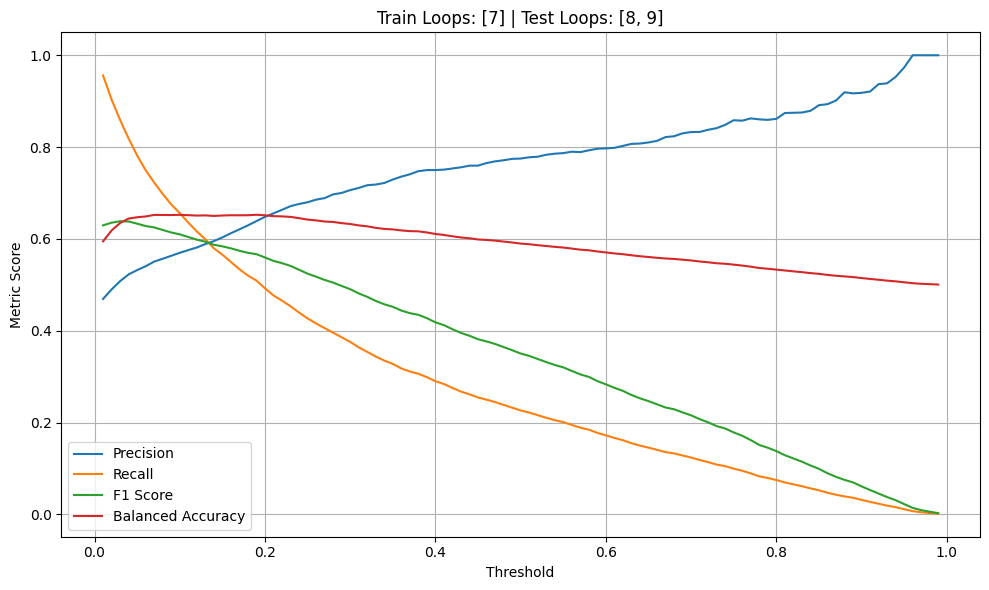

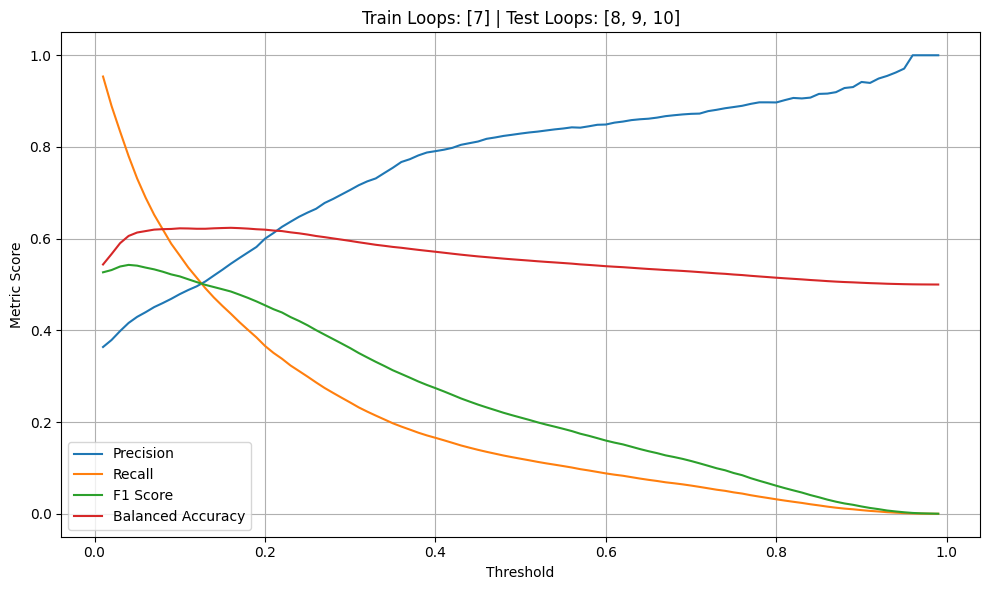

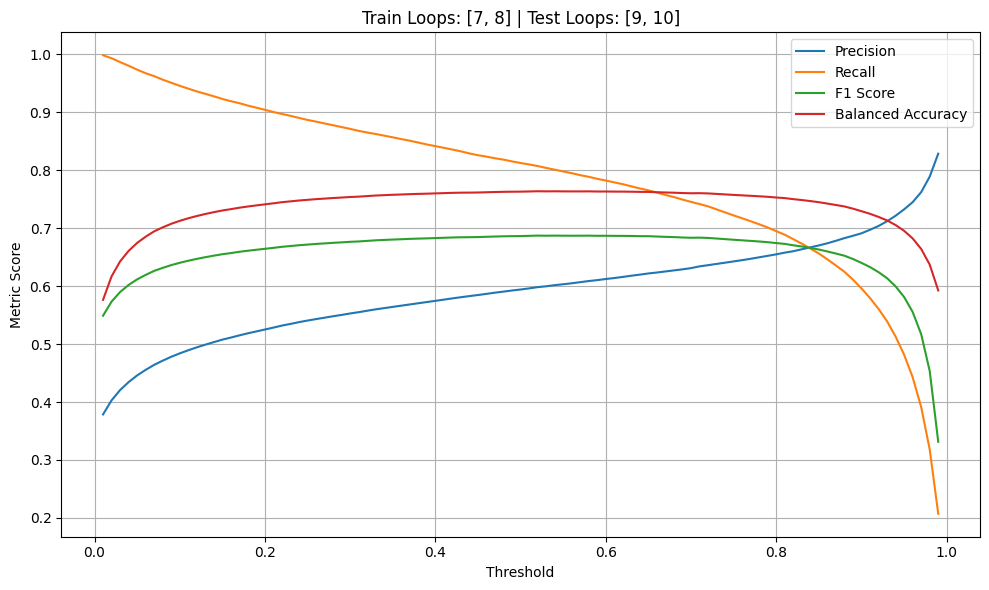

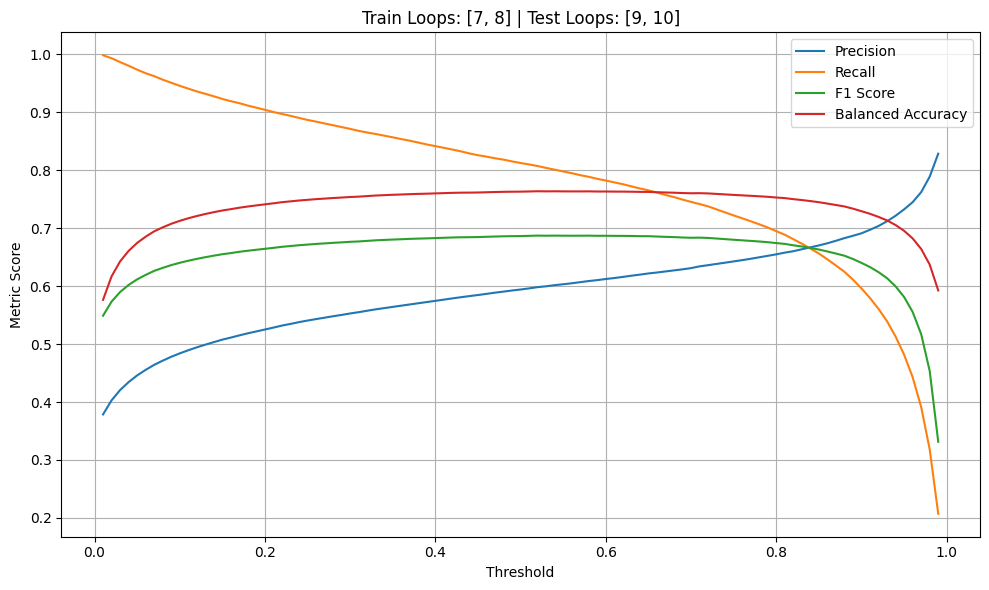

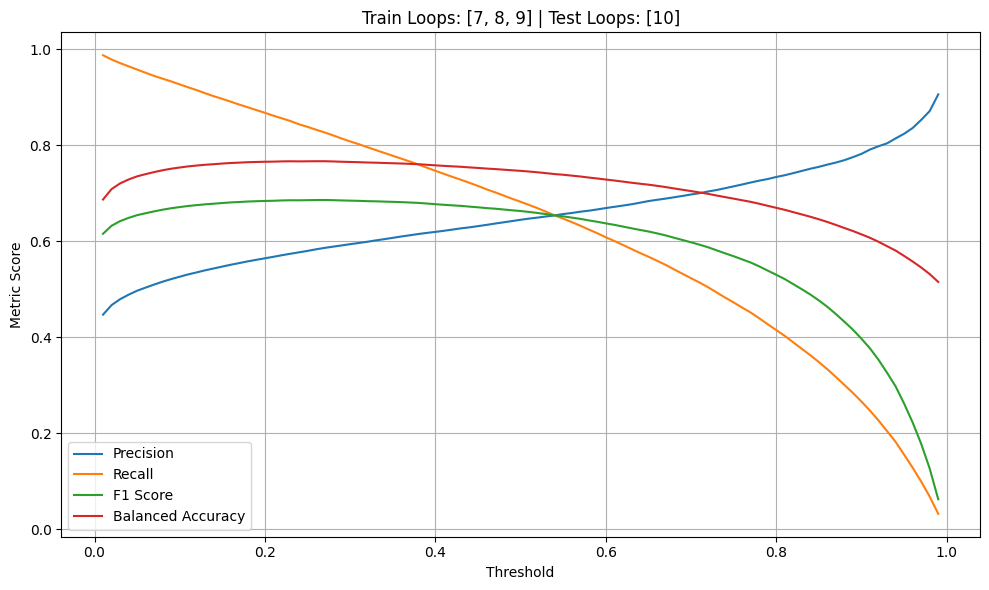

In [18]:
from sklearn.metrics import precision_score, recall_score, f1_score, balanced_accuracy_score, roc_auc_score
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import numpy as np

# --- Define loops to use ---
train_loops = [7,8, 9]
test_loops = [10]

# --- Split data ---
train_data = all_loops[all_loops['loops'].isin(train_loops)]
test_data  = all_loops[all_loops['loops'].isin(test_loops)]

# --- Columns ---
target_col   = 'COEFFICIENTS'
# Use all columns except the target and the loop id as features
feature_cols = [c for c in all_loops.columns if c not in [target_col, 'loops']]

# --- Train data ---
X_train_full = train_data[feature_cols].values
y_train_full = train_data[target_col].values.ravel()

# --- Test data ---
X_test   = test_data[feature_cols].values
y_test   = test_data[target_col].values.ravel()
loop_test = test_data['loops'].values

# --- Train a single model on ALL training data ---
model = XGBClassifier(eval_metric='logloss', use_label_encoder=False)
model.fit(X_train_full, y_train_full)

# --- Predict on the combined test set ---
test_scores = model.predict_proba(X_test)[:, 1]

# --- AUC per test loop ---
per_loop_auc = {}
for loop_id in test_loops:
    mask = (loop_test == loop_id)
    if mask.sum() > 0:
        auc = roc_auc_score(y_test[mask], test_scores[mask])
        per_loop_auc[loop_id] = auc
        print(f"AUC (loop {loop_id}): {auc:.3f}")
    else:
        print(f"No samples for loop {loop_id} in test set")

# --- (Optional) AUC on the training data just for reference ---
train_scores = model.predict_proba(X_train_full)[:, 1]
train_auc = roc_auc_score(y_train_full, train_scores)
print(f"AUC (train loops {train_loops}): {train_auc:.3f}")

# --- Threshold sweep on the combined test set ---
thresholds = np.linspace(0.01, 0.99, 99)

precisions = []
recalls = []
f1s = []
balanced_accuracies = []

for t in thresholds:
    y_pred = (test_scores >= t).astype(int)
    precisions.append(precision_score(y_test, y_pred, zero_division=0))
    recalls.append(recall_score(y_test, y_pred))
    f1s.append(f1_score(y_test, y_pred))
    balanced_accuracies.append(balanced_accuracy_score(y_test, y_pred))

precisions = np.array(precisions)
recalls = np.array(recalls)
f1s = np.array(f1s)
balanced_accuracies = np.array(balanced_accuracies)

print("\nSummary:")
print(f"  Train AUC (loops {train_loops}): {train_auc:.3f}")
for loop_id in test_loops:
    if loop_id in per_loop_auc:
        print(f"  Test AUC (loop {loop_id}): {per_loop_auc[loop_id]:.3f}")

# --- Plot metrics vs threshold (combined test set) ---
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precisions, label="Precision")
plt.plot(thresholds, recalls, label="Recall")
plt.plot(thresholds, f1s, label="F1 Score")
plt.plot(thresholds, balanced_accuracies, label="Balanced Accuracy")
plt.xlabel("Threshold")
plt.ylabel("Metric Score")
plt.title(f"Train Loops: {train_loops} | Test Loops: {test_loops}")
plt.legend()
plt.grid(True)
plt.tight_layout()
#plt.savefig('/Users/rezadoobary/Documents/ML-correlator/Tree classifier for graphs/mixed_loops/docs/assets/789_10.png')
plt.show()


In [8]:
train_data.shape

(168820, 58)

In [9]:
test_data.shape

(1697302, 58)

/opt/miniconda3/envs/torch-env/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [21:24:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


AUC (loop 10): 0.968
AUC (train loops [10]): 0.968

Summary:
  Train AUC (loops [10]): 0.968
  Test AUC (loop 10): 0.968


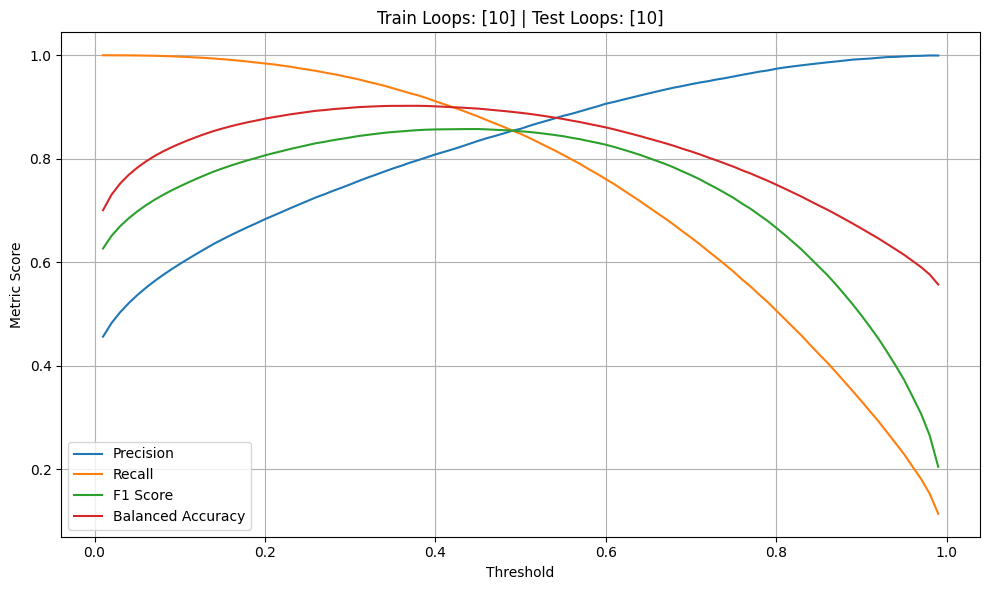

In [20]:
from sklearn.metrics import precision_score, recall_score, f1_score, balanced_accuracy_score, roc_auc_score
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import numpy as np

# --- Define loops to use ---
train_loops = [10]
test_loops = [10]

# --- Split data ---
train_data = all_loops[all_loops['loops'].isin(train_loops)]
test_data  = all_loops[all_loops['loops'].isin(test_loops)]

# --- Columns ---
target_col   = 'COEFFICIENTS'
# Use all columns except the target and the loop id as features
feature_cols = [c for c in all_loops.columns if c not in [target_col, 'loops']]

# --- Train data ---
X_train_full = train_data[feature_cols].values
y_train_full = train_data[target_col].values.ravel()

# --- Test data ---
X_test   = test_data[feature_cols].values
y_test   = test_data[target_col].values.ravel()
loop_test = test_data['loops'].values


# --- Train a single model on ALL training data ---
model = XGBClassifier(eval_metric='logloss', use_label_encoder=False)
model.fit(X_train_full, y_train_full)

# --- Predict on the combined test set ---
test_scores = model.predict_proba(X_test)[:, 1]

# --- AUC per test loop ---
per_loop_auc = {}
for loop_id in test_loops:
    mask = (loop_test == loop_id)
    if mask.sum() > 0:
        auc = roc_auc_score(y_test[mask], test_scores[mask])
        per_loop_auc[loop_id] = auc
        print(f"AUC (loop {loop_id}): {auc:.3f}")
    else:
        print(f"No samples for loop {loop_id} in test set")

# --- (Optional) AUC on the training data just for reference ---
train_scores = model.predict_proba(X_train_full)[:, 1]
train_auc = roc_auc_score(y_train_full, train_scores)
print(f"AUC (train loops {train_loops}): {train_auc:.3f}")

# --- Threshold sweep on the combined test set ---
thresholds = np.linspace(0.01, 0.99, 99)

precisions = []
recalls = []
f1s = []
balanced_accuracies = []

for t in thresholds:
    y_pred = (test_scores >= t).astype(int)
    precisions.append(precision_score(y_test, y_pred, zero_division=0))
    recalls.append(recall_score(y_test, y_pred))
    f1s.append(f1_score(y_test, y_pred))
    balanced_accuracies.append(balanced_accuracy_score(y_test, y_pred))

precisions = np.array(precisions)
recalls = np.array(recalls)
f1s = np.array(f1s)
balanced_accuracies = np.array(balanced_accuracies)

print("\nSummary:")
print(f"  Train AUC (loops {train_loops}): {train_auc:.3f}")
for loop_id in test_loops:
    if loop_id in per_loop_auc:
        print(f"  Test AUC (loop {loop_id}): {per_loop_auc[loop_id]:.3f}")

# --- Plot metrics vs threshold (combined test set) ---
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precisions, label="Precision")
plt.plot(thresholds, recalls, label="Recall")
plt.plot(thresholds, f1s, label="F1 Score")
plt.plot(thresholds, balanced_accuracies, label="Balanced Accuracy")
plt.xlabel("Threshold")
plt.ylabel("Metric Score")
plt.title(f"Train Loops: {train_loops} | Test Loops: {test_loops}")
plt.legend()
plt.grid(True)
plt.tight_layout()
#plt.savefig('/Users/rezadoobary/Documents/ML-correlator/Tree classifier for graphs/mixed_loops/docs/assets/78910_11.png')
plt.show()


In [44]:
from itertools import combinations
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score
from xgboost import XGBClassifier

# --- Fixed test loop ---
TEST_LOOP = 9

# --- Candidate train loops ---
CANDIDATE_LOOPS = [7, 8]

# --- Columns ---
target_col   = 'COEFFICIENTS'
feature_cols = [c for c in all_loops.columns if c not in [target_col, 'loops']]

# --- Pre-slice test data once ---
test_data = all_loops[all_loops['loops'] == TEST_LOOP]
if test_data.empty:
    raise ValueError(f"No samples for test loop {TEST_LOOP}.")

X_test = test_data[feature_cols].values
y_test = test_data[target_col].values.ravel()

results = []
train_loop_perf_rows = []

# iterate over all non-empty combinations of candidate train loops
for r in range(1, len(CANDIDATE_LOOPS) + 1):
    for train_loops in combinations(CANDIDATE_LOOPS, r):
        train_data = all_loops[all_loops['loops'].isin(train_loops)]
        if train_data.empty:
            continue

        y_train = train_data[target_col].values.ravel()
        if len(np.unique(y_train)) < 2:
            # cannot train a classifier on a single class
            continue

        X_train = train_data[feature_cols].values

        # --- Train model on this combo ---
        model = XGBClassifier(eval_metric='logloss', use_label_encoder=False)
        model.fit(X_train, y_train)

        # --- Train AUC (overall on all training rows) ---
        train_scores_all = model.predict_proba(X_train)[:, 1]
        train_auc_all = roc_auc_score(y_train, train_scores_all)

        # --- Per-loop AUCs within training set ---
        for loop_id in train_loops:
            loop_mask = (train_data['loops'].values == loop_id)
            y_loop = y_train[loop_mask]
            # handle single-class slices safely
            if len(np.unique(y_loop)) < 2:
                loop_auc = np.nan
            else:
                loop_scores = train_scores_all[loop_mask]
                loop_auc = roc_auc_score(y_loop, loop_scores)

            train_loop_perf_rows.append({
                "train_loops": tuple(train_loops),
                "loop_id": loop_id,
                "n_train_loop": int(loop_mask.sum()),
                "train_auc_loop": loop_auc
            })

        # --- Test AUC on loop 11 ---
        test_scores = model.predict_proba(X_test)[:, 1]
        test_auc = roc_auc_score(y_test, test_scores)

        results.append({
            "train_loops": tuple(train_loops),
            "n_train": len(train_data),
            "train_auc_overall": train_auc_all,
            "test_loop": TEST_LOOP,
            "test_auc": test_auc
        })

# --- Summaries ---
results_df = pd.DataFrame(results).sort_values(by=["test_auc", "train_auc_overall"], ascending=False)

train_loop_perf_df = pd.DataFrame(train_loop_perf_rows)
# (optional) pivot to wide format if you prefer one row per combo:
# wide_train_loop_perf = train_loop_perf_df.pivot(index="train_loops", columns="loop_id", values="train_auc_loop")

print("=== Overall by combo ===")
print(results_df.to_string(index=False))

print("\n=== Training per-loop AUCs (long-form) ===")
print(train_loop_perf_df.sort_values(["train_loops","loop_id"]).to_string(index=False))


/opt/miniconda3/envs/torch-env/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [21:56:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/miniconda3/envs/torch-env/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [21:56:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/miniconda3/envs/torch-env/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [21:56:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


=== Overall by combo ===
train_loops  n_train  train_auc_overall  test_loop  test_auc
     (7, 8)     2929                1.0          9  0.879266
       (8,)     2709                1.0          9  0.871598
       (7,)      220                1.0          9  0.783201

=== Training per-loop AUCs (long-form) ===
train_loops  loop_id  n_train_loop  train_auc_loop
       (7,)        7           220             1.0
     (7, 8)        7           220             1.0
     (7, 8)        8          2709             1.0
       (8,)        8          2709             1.0


Fold 1 ROC AUC (loop 7): 0.756
Fold 1 ROC AUC (loop 10): 0.918
Fold 2 ROC AUC (loop 7): 0.736
Fold 2 ROC AUC (loop 10): 0.917
Fold 3 ROC AUC (loop 7): 0.774
Fold 3 ROC AUC (loop 10): 0.915
Fold 4 ROC AUC (loop 7): 0.810
Fold 4 ROC AUC (loop 10): 0.916
Fold 5 ROC AUC (loop 7): 0.662
Fold 5 ROC AUC (loop 10): 0.915

Average ROC AUC for loop 7: 0.747 ± 0.049
Average ROC AUC for loop 10: 0.916 ± 0.001


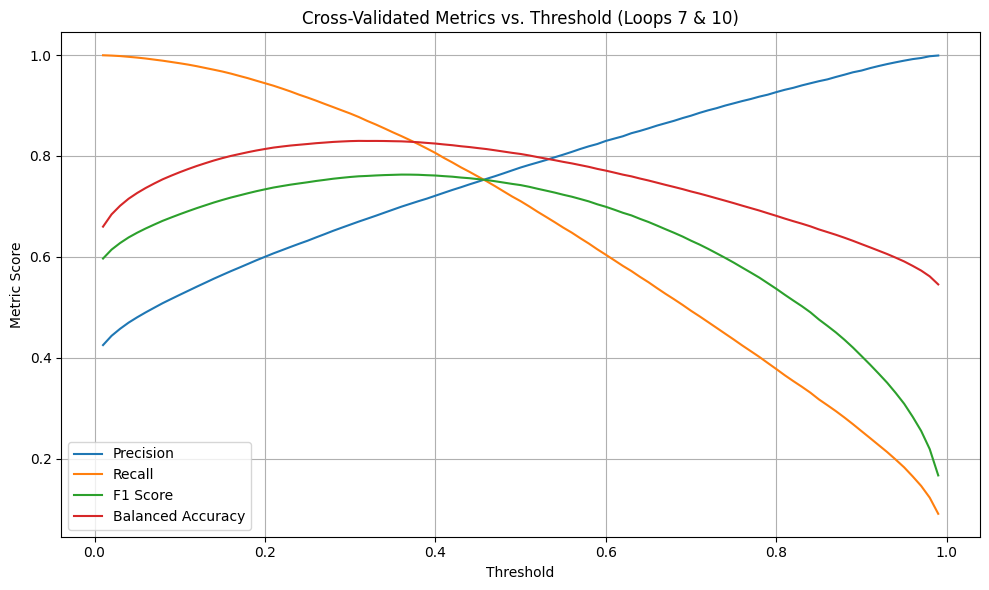

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, f1_score, balanced_accuracy_score, roc_auc_score
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import numpy as np

# --- Filter data: train/test only on loops 7 & 8 ---
data = all_loops[all_loops['loops'].isin([7,10])]

# --- Setup ---
data_cols = [col for col in data.columns if 'COEFFICIENTS' not in col]
target_col = 'COEFFICIENTS'
stratify_labels = data[target_col].astype(str) + "_" + data["loops"].astype(str)

X = data[data_cols].values
y = data[target_col].values.ravel()
loops = data["loops"].values  # to track per-test-loop performance

# --- Thresholds for precision/recall curves ---
thresholds = np.linspace(0.01, 0.99, 99)
precisions = np.zeros_like(thresholds)
recalls = np.zeros_like(thresholds)
f1s = np.zeros_like(thresholds)
balanced_accuracies = np.zeros_like(thresholds)

# --- Store ROC AUC per loop, per fold ---
loop8_aucs = []
loop9_aucs = []

# --- Cross-validation ---
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for fold, (train_idx, test_idx) in enumerate(kf.split(X, stratify_labels)):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    loop_test = loops[test_idx]

    # Optional: scaling
    # scaler = StandardScaler()
    # X_train = scaler.fit_transform(X_train)
    # X_test = scaler.transform(X_test)

    model = XGBClassifier(eval_metric='logloss')
    model.fit(X_train, y_train)
    y_scores = model.predict_proba(X_test)[:, 1]

    # --- AUCs per loop value ---
    for loop_id, auc_list in [(7, loop8_aucs), (10, loop9_aucs)]:
        mask = loop_test == loop_id
        if mask.sum() > 0:
            auc = roc_auc_score(y_test[mask], y_scores[mask])
            auc_list.append(auc)
            print(f"Fold {fold+1} ROC AUC (loop {loop_id}): {auc:.3f}")
        else:
            print(f"Fold {fold+1} has no samples for loop {loop_id}")

    # --- Threshold-dependent metrics ---
    for i, t in enumerate(thresholds):
        y_pred = (y_scores >= t).astype(int)
        precisions[i] += precision_score(y_test, y_pred, zero_division=0)
        recalls[i] += recall_score(y_test, y_pred)
        f1s[i] += f1_score(y_test, y_pred)
        balanced_accuracies[i] += balanced_accuracy_score(y_test, y_pred)

# --- Average threshold metrics ---
n_folds = kf.get_n_splits()
precisions /= n_folds
recalls /= n_folds
f1s /= n_folds
balanced_accuracies /= n_folds

# --- Report average AUCs ---
print(f"\nAverage ROC AUC for loop 7: {np.mean(loop8_aucs):.3f} ± {np.std(loop8_aucs):.3f}")
print(f"Average ROC AUC for loop 10: {np.mean(loop9_aucs):.3f} ± {np.std(loop9_aucs):.3f}")

# --- Plot metrics vs threshold ---
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precisions, label="Precision")
plt.plot(thresholds, recalls, label="Recall")
plt.plot(thresholds, f1s, label="F1 Score")
plt.plot(thresholds, balanced_accuracies, label="Balanced Accuracy")

plt.xlabel("Threshold")
plt.ylabel("Metric Score")
plt.title("Cross-Validated Metrics vs. Threshold (Loops 7 & 10)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [20]:
##### STOP HERE

In [21]:
# cluster the data and let's see what preditive power we get

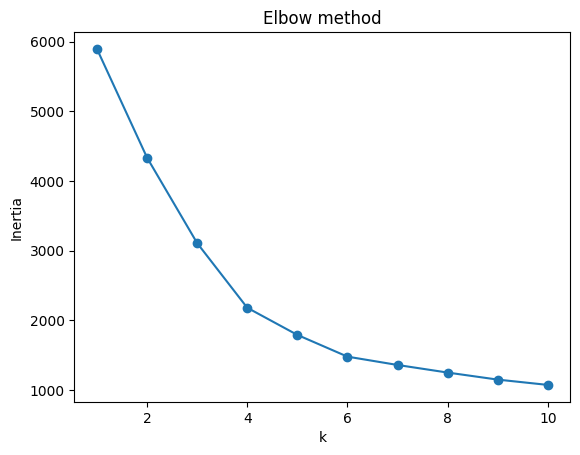

Suggested k = 4


In [22]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np

loop7 = all_loops[all_loops['loops'] == 7]
loop7 = loop7.dropna(axis = 1)
data_cols = [col for col in loop7.columns if 'COEFFICIENTS' not in col]
X = loop7[data_cols]

inertias = []
for k in range(1, 11):
    inertias.append(KMeans(n_clusters=k, random_state=42, n_init=10)
                    .fit(X).inertia_)

plt.plot(range(1, 11), inertias, marker='o')
plt.xlabel("k"); plt.ylabel("Inertia"); plt.title("Elbow method"); plt.show()

second_deriv = np.diff(inertias, 2)
elbow_k = np.argmax(second_deriv) + 2
print("Suggested k =", elbow_k)

kmeans = KMeans(n_clusters=elbow_k, random_state=42, n_init=10)
labels = kmeans.fit_predict(X)


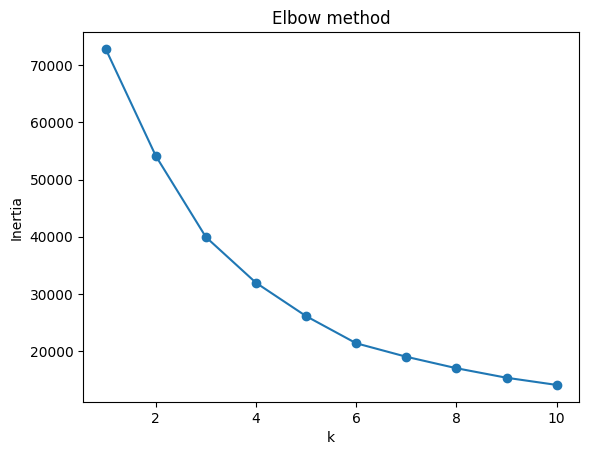

Suggested k = 3


In [23]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np

loop7 = all_loops[all_loops['loops'] == 8]
loop7 = loop7.dropna(axis = 1)
data_cols = [col for col in loop7.columns if 'COEFFICIENTS' not in col]
X = loop7[data_cols]

inertias = []
for k in range(1, 11):
    inertias.append(KMeans(n_clusters=k, random_state=42, n_init=10)
                    .fit(X).inertia_)

plt.plot(range(1, 11), inertias, marker='o')
plt.xlabel("k"); plt.ylabel("Inertia"); plt.title("Elbow method"); plt.show()

second_deriv = np.diff(inertias, 2)
elbow_k = np.argmax(second_deriv) + 2
print("Suggested k =", elbow_k)

kmeans = KMeans(n_clusters=elbow_k, random_state=42, n_init=10)
labels = kmeans.fit_predict(X)


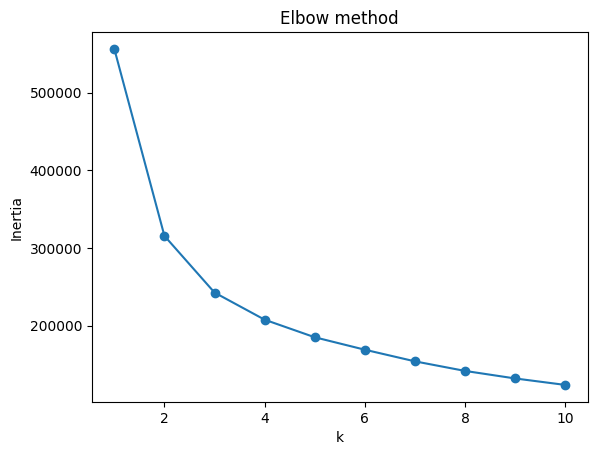

Suggested k = 2


In [24]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np

loop7 = all_loops[all_loops['loops'] == 9]
loop7 = loop7.dropna(axis = 1)
data_cols = [col for col in loop7.columns if 'COEFFICIENTS' not in col]
X = loop7[data_cols]

inertias = []
for k in range(1, 11):
    inertias.append(KMeans(n_clusters=k, random_state=42, n_init=10)
                    .fit(X).inertia_)

plt.plot(range(1, 11), inertias, marker='o')
plt.xlabel("k"); plt.ylabel("Inertia"); plt.title("Elbow method"); plt.show()

second_deriv = np.diff(inertias, 2)
elbow_k = np.argmax(second_deriv) + 2
print("Suggested k =", elbow_k)

kmeans = KMeans(n_clusters=elbow_k, random_state=42, n_init=10)
labels = kmeans.fit_predict(X)


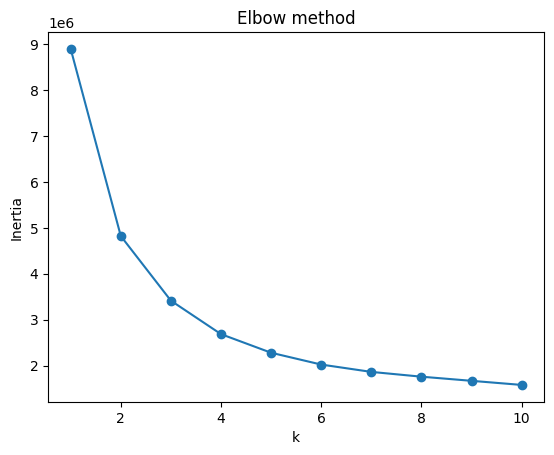

Suggested k = 2


In [25]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np

loop7 = all_loops[all_loops['loops'] == 10]
loop7 = loop7.dropna(axis = 1)
data_cols = [col for col in loop7.columns if 'COEFFICIENTS' not in col]
X = loop7[data_cols]

inertias = []
for k in range(1, 11):
    inertias.append(KMeans(n_clusters=k, random_state=42, n_init=10)
                    .fit(X).inertia_)

plt.plot(range(1, 11), inertias, marker='o')
plt.xlabel("k"); plt.ylabel("Inertia"); plt.title("Elbow method"); plt.show()

second_deriv = np.diff(inertias, 2)
elbow_k = np.argmax(second_deriv) + 2
print("Suggested k =", elbow_k)

kmeans = KMeans(n_clusters=elbow_k, random_state=42, n_init=10)
labels = kmeans.fit_predict(X)


In [26]:
# let's take 20

In [62]:
"""
Goal
----
Find which cluster (from the ten test loops) you should add to the
training data to maximise performance on the rest of the test set.
"""

import warnings
from collections import defaultdict
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.cluster import KMeans
from xgboost import XGBClassifier

# ------------------------------------------------------------
# USER SETTINGS
# ------------------------------------------------------------
train_loops  = [7, 8, 9]          # original train loops
test_loops   = list(range(1, 11)) # ten loops → will be clustered
random_state = 42
n_splits     = 5
n_clusters   = 20                 # exactly 10 clusters on the test set
# ------------------------------------------------------------

# ------------------  split data -----------------------------
train_df = all_loops[all_loops["loops"].isin(train_loops)].reset_index(drop=True)
test_df  = all_loops[all_loops["loops"].isin(test_loops )].reset_index(drop=True)

feature_cols = [c for c in all_loops.columns if c not in ("COEFFICIENTS", "loops")]
target_col   = "COEFFICIENTS"

X_train_base = train_df[feature_cols].values
y_train_base = train_df[target_col].values.ravel()

X_test_df    = test_df[feature_cols].copy()      # keep NaNs for XGB
y_test_full  = test_df[target_col].values.ravel()
loops_full   = test_df["loops"].values

# ------------------  cluster test set ----------------------
X_cluster = X_test_df.dropna(axis=1).values      # drop NaN columns for KMeans
kmeans    = KMeans(n_clusters=n_clusters, n_init="auto", random_state=random_state)
clusters  = kmeans.fit_predict(X_cluster)

# ------------------  function: train & score ---------------
def train_and_score(X_train, y_train, X_test, y_test):
    """
    Train a fresh XGB (single fit, no CV) and return ROC-AUC on X_test.
    """
    model = XGBClassifier(eval_metric="logloss", random_state=random_state)
    model.fit(X_train, y_train)
    prob = model.predict_proba(X_test)[:, 1]
    auc  = roc_auc_score(y_test, prob)
    return auc, prob

# ---------- main experiment (unchanged except for bookkeeping) ----------
results = []

for cl in range(n_clusters):
    in_clust  = clusters == cl
    out_clust = ~in_clust

    X_train = np.vstack([X_train_base, X_test_df[in_clust].values])
    y_train = np.concatenate([y_train_base, y_test_full[in_clust]])

    X_test  = X_test_df[out_clust].values
    y_test  = y_test_full[out_clust]
    loops   = loops_full[out_clust]

    auc, prob = train_and_score(X_train, y_train, X_test, y_test)

    results.append(
        dict(cluster=cl,
             added_rows=in_clust.sum(),
             remaining_rows=out_clust.sum(),
             final_train_rows=X_train.shape[0],
             final_test_rows=X_test.shape[0],
             overall_auc=auc,
             auc_by_loop={
                 lp: roc_auc_score(y_test[loops == lp], prob[loops == lp])
                 for lp in np.unique(loops)
             })
    )

# ------------------  report -------------------------------
print("\n=== PROMOTE-ONE-CLUSTER RESULTS ===")
for r in results:
    print(f"Cluster {r['cluster']:2d} | "
          f"rows→train {r['added_rows']:5d} | "
          f"remaining test {r['remaining_rows']:5d} | "
          f"AUC = {r['overall_auc']:.3f}")

best = max(results, key=lambda r: r["overall_auc"])

print(f"\n>>> Add cluster {best['cluster']} "
      f"→ best AUC {best['overall_auc']:.3f}")
print(f"Final TRAIN size = {best['final_train_rows']} rows")
print(f"Final TEST  size = {best['final_test_rows']} rows")

print("\nPer-loop AUC after adding that cluster:")
for lp, score in sorted(best["auc_by_loop"].items()):
    print(f"  Loop {lp:2d} · AUC = {score:.3f}")


=== PROMOTE-ONE-CLUSTER RESULTS ===
Cluster  0 | rows→train 21310 | remaining test 147510 | AUC = 0.889
Cluster  1 | rows→train  4927 | remaining test 163893 | AUC = 0.831
Cluster  2 | rows→train 12960 | remaining test 155860 | AUC = 0.864
Cluster  3 | rows→train  2294 | remaining test 166526 | AUC = 0.850
Cluster  4 | rows→train  1424 | remaining test 167396 | AUC = 0.852
Cluster  5 | rows→train 15156 | remaining test 153664 | AUC = 0.890
Cluster  6 | rows→train  2467 | remaining test 166353 | AUC = 0.849
Cluster  7 | rows→train 16574 | remaining test 152246 | AUC = 0.878
Cluster  8 | rows→train 21277 | remaining test 147543 | AUC = 0.890
Cluster  9 | rows→train   143 | remaining test 168677 | AUC = 0.834
Cluster 10 | rows→train  6077 | remaining test 162743 | AUC = 0.838
Cluster 11 | rows→train   654 | remaining test 168166 | AUC = 0.828
Cluster 12 | rows→train  2600 | remaining test 166220 | AUC = 0.871
Cluster 13 | rows→train  6539 | remaining test 162281 | AUC = 0.830
Cluster 14 

In [63]:
# ------------------------------------------------------------
# 1️⃣  First pass (unchanged) – pick the single best cluster
# ------------------------------------------------------------
first_pass = []

for cl in range(n_clusters):
    mask_in  = clusters == cl
    mask_out = ~mask_in

    X_train = np.vstack([X_train_base, X_test_df[mask_in].values])
    y_train = np.concatenate([y_train_base, y_test_full[mask_in]])

    auc, _  = train_and_score(X_train, y_train,
                              X_test_df[mask_out].values,
                              y_test_full[mask_out])

    first_pass.append((cl, auc))

best1, best1_auc = max(first_pass, key=lambda t: t[1])
print(f"▶ Best first cluster = {best1}  (AUC = {best1_auc:.3f})")

# ------------------------------------------------------------
# 2️⃣  Second pass – pick the best *additional* cluster
# ------------------------------------------------------------
mask_best1 = clusters == best1          # already promoted
X_train_lvl1 = np.vstack([X_train_base,
                          X_test_df[mask_best1].values])
y_train_lvl1 = np.concatenate([y_train_base,
                               y_test_full[mask_best1]])

second_pass = []

for cl in range(n_clusters):
    if cl == best1:
        continue                       # skip the one we already added

    mask_in  = (clusters == cl)
    mask_out = ~(mask_best1 | mask_in) # still-held-out data

    X_train = np.vstack([X_train_lvl1, X_test_df[mask_in].values])
    y_train = np.concatenate([y_train_lvl1, y_test_full[mask_in]])

    auc, _ = train_and_score(X_train, y_train,
                             X_test_df[mask_out].values,
                             y_test_full[mask_out])

    second_pass.append((cl, auc))

best2, best2_auc = max(second_pass, key=lambda t: t[1])

print("\n=== TWO-CLUSTER PROMOTION RESULT ===")
print(f"1st cluster promoted : {best1}")
print(f"2nd cluster promoted : {best2}")
print(f"AUC after two clusters: {best2_auc:.3f}")


▶ Best first cluster = 5  (AUC = 0.890)

=== TWO-CLUSTER PROMOTION RESULT ===
1st cluster promoted : 5
2nd cluster promoted : 8
AUC after two clusters: 0.908


In [64]:
# ------------------------------------------------------------
# Utility: return overall AUC after promoting a given set of clusters
# ------------------------------------------------------------
def auc_with_clusters(promoted):
    """
    promoted : iterable of cluster IDs already moved to the train fold
    """
    promoted_mask = np.isin(clusters, promoted)

    X_train = np.vstack([X_train_base, X_test_df[promoted_mask].values])
    y_train = np.concatenate([y_train_base, y_test_full[promoted_mask]])

    X_hold  = X_test_df[~promoted_mask].values
    y_hold  = y_test_full[~promoted_mask]

    auc, _ = train_and_score(X_train, y_train, X_hold, y_hold)
    return auc

# ------------------------------------------------------------
# We already have best1 and best2 from the earlier passes
# ------------------------------------------------------------
selected = [best1, best2]
current_auc = auc_with_clusters(selected)
print(f"AUC after clusters {selected}: {current_auc:.3f}")

# ------------------------------------------------------------
# 3️⃣  Third pass – pick the next best cluster
# ------------------------------------------------------------
candidates = [c for c in range(n_clusters) if c not in selected]

improvements = []
for c in candidates:
    auc_c = auc_with_clusters(selected + [c])
    improvements.append((c, auc_c))

best3, best3_auc = max(improvements, key=lambda t: t[1])
selected.append(best3)

print("\n=== THREE-CLUSTER PROMOTION RESULT ===")
print(f"Clusters promoted : {selected}")
print(f"AUC after three clusters: {best3_auc:.3f}")


AUC after clusters [5, 8]: 0.907

=== THREE-CLUSTER PROMOTION RESULT ===
Clusters promoted : [5, 8, 19]
AUC after three clusters: 0.917


In [67]:
np.sum([c in [5, 8, 19] for c in clusters])

np.int64(50783)

In [31]:
(all_loops[all_loops['loops'] == 9].shape[0]/5)*4

11177.6

In [72]:
len(all_loops[all_loops['loops'] == 10])*0.8

122601.6

In [33]:
#loops 7,8,9 and lesser parts of 10 would be helpful in scoring 10 better than others.

In [34]:
# what coefficients of 10 are hard to find using cusp relation or switch when using each method?

In [35]:
pd.Series(clusters).value_counts().sort_index()

0     1336
1      568
2     1905
3       66
4     1702
5      435
6     1116
7     1629
8       97
9     1294
10     696
11     336
12     535
13       7
14       1
15      98
16    1843
17     165
18    1256
19     483
Name: count, dtype: int64

Fold 1 ROC AUC: 0.906
Fold 2 ROC AUC: 0.908
Fold 3 ROC AUC: 0.906

Average ROC AUC: 0.907 ± 0.001


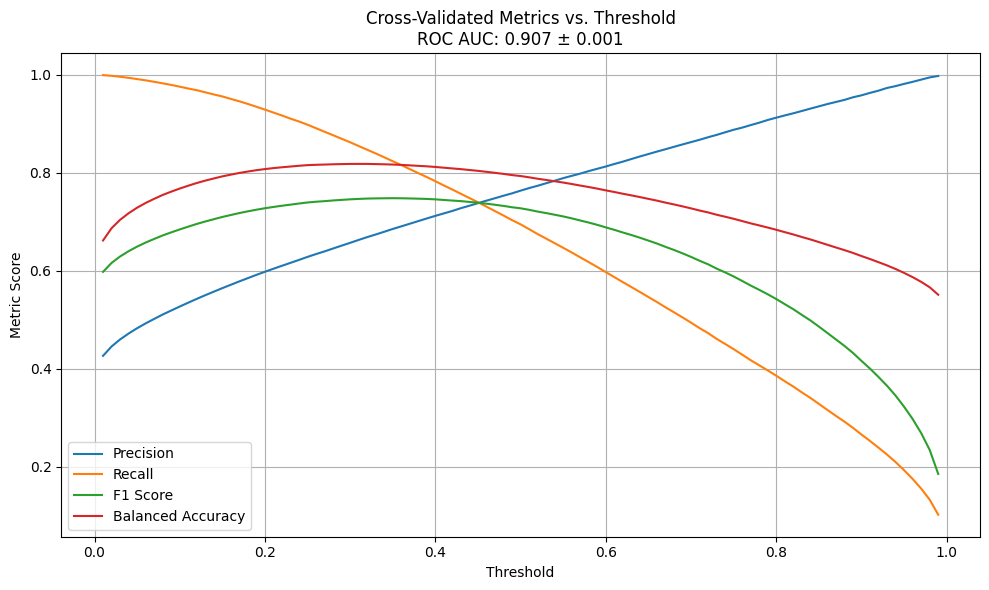

In [78]:
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    precision_score, recall_score, f1_score,
    balanced_accuracy_score, roc_auc_score
)
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import numpy as np

# --- Data ---
data = loop10_data
data_cols = [col for col in data.columns if 'COEFFICIENTS' not in col]
target_col = 'COEFFICIENTS'
X = data[data_cols].values
y = data[target_col].values.ravel()

# --- Thresholds ---
thresholds = np.linspace(0.01, 0.99, 99)
precisions = np.zeros_like(thresholds)
recalls = np.zeros_like(thresholds)
f1s = np.zeros_like(thresholds)
balanced_accuracies = np.zeros_like(thresholds)
splits = 3

# --- Track ROC AUC per fold
roc_aucs = []

# --- Stratified K-Fold CV ---
kf = StratifiedKFold(n_splits=splits, shuffle=True, random_state=42)

for fold, (train_idx, test_idx) in enumerate(kf.split(X, y)):
    X_test, X_train = X[train_idx], X[test_idx]
    y_test, y_train = y[train_idx], y[test_idx]

    # --- Scaling (fit on train only, transform both train/test) ---
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # --- Model training ---
    model = XGBClassifier(eval_metric='logloss')
    model.fit(X_train, y_train)

    y_scores = model.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, y_scores)
    roc_aucs.append(auc)
    print(f"Fold {fold+1} ROC AUC: {auc:.3f}")

    for i, t in enumerate(thresholds):
        y_pred = (y_scores >= t).astype(int)
        precisions[i] += precision_score(y_test, y_pred, zero_division=0)
        recalls[i] += recall_score(y_test, y_pred)
        f1s[i] += f1_score(y_test, y_pred)
        balanced_accuracies[i] += balanced_accuracy_score(y_test, y_pred)

# --- Average metrics across folds ---
n_folds = kf.get_n_splits()
precisions /= n_folds
recalls /= n_folds
f1s /= n_folds
balanced_accuracies /= n_folds

# --- Report AUC ---
mean_auc = np.mean(roc_aucs)
std_auc = np.std(roc_aucs)
print(f"\nAverage ROC AUC: {mean_auc:.3f} ± {std_auc:.3f}")

# --- Plot ---
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precisions, label="Precision")
plt.plot(thresholds, recalls, label="Recall")
plt.plot(thresholds, f1s, label="F1 Score")
plt.plot(thresholds, balanced_accuracies, label="Balanced Accuracy")

plt.xlabel("Threshold")
plt.ylabel("Metric Score")
plt.title(f"Cross-Validated Metrics vs. Threshold\nROC AUC: {mean_auc:.3f} ± {std_auc:.3f}")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
